In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Beta
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

In [2]:
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# 定义超参数
num_steps = 2000        # 每次收集的数据步数
mini_batch_size = 128    # 小批量大小
ppo_epochs = 8         # PPO的更新轮次
gamma = 0.99            # 折扣因子
lambda_gae = 0.95       # GAE参数
clip_eps = 0.1          # PPO的截断阈值
value_loss_coef = 0.5   # 价值损失系数
entropy_coef = 0.05     # 熵正则化系数
learning_rate = 0.0001    # 学习率
max_grad_norm = 0.5     # 梯度裁剪

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_shape, action_dim):
        super(ActorCritic, self).__init__()

        # 卷积层处理图像输入
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        conv_out_size = self._get_conv_out(state_shape)

        # 策略网络
        self.pi_hidden = nn.Sequential(
            nn.Linear(conv_out_size, 100),
            nn.LeakyReLU()
        )

        self.pi_alpha = nn.Sequential(
            nn.Linear(100, action_dim),
            nn.Softplus()
        )

        self.pi_beta = nn.Sequential(
            nn.Linear(100, action_dim),
            nn.Softplus()
        )

        # 价值网络
        self.v = nn.Sequential(
            nn.Linear(conv_out_size, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 1)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, shape[2], shape[0], shape[1]))
        return o.size()[1]

    def forward(self, x):
        x = x.permute(0, 3, 1, 2).float() / 255.0 # 归一化
        conv_out = self.conv(x) # 获取隐空间向量
        # conv_out = conv_out.reshape(x.size()[0], -1) # 展平

        # 策略网络
        pi_h = self.pi_hidden(conv_out)
        alpha = self.pi_alpha(pi_h) + 1
        beta = self.pi_beta(pi_h) + 1

        # 价值网络
        value = self.v(conv_out)

        return alpha, beta, value

In [6]:
def collect_rollout(env, policy, num_steps):
    states = torch.empty((num_steps, 96, 96, 3), dtype=torch.float32)
    actions = torch.empty((num_steps, 3), dtype=torch.float32)
    log_probs = torch.empty((num_steps,), dtype=torch.float32)
    rewards = torch.empty((num_steps,), dtype=torch.float32)
    dones = torch.empty((num_steps,), dtype=torch.float32)
    values = torch.empty((num_steps, 1), dtype=torch.float32)

    state = env.reset()[0]

    for t in range(num_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            alpha, beta, value = policy(state_tensor)
        dist = Beta(alpha, beta)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)  # 求和得到对数概率

        action_transform = action.squeeze().cpu().numpy()
        action_transform = action_transform * (env.action_space.high - env.action_space.low) + env.action_space.low
    
        next_state, reward, terminated, truncated, _ = env.step(action_transform)
        done = terminated or truncated
        
        states[t] = torch.FloatTensor(state)
        actions[t] = action
        log_probs[t] = log_prob
        rewards[t] = reward
        dones[t] = done
        values[t] = value

        state = next_state if not done else env.reset()[0]
    states = states.to(device)
    actions = actions.to(device)
    log_probs = log_probs.to(device)
    rewards = rewards.to(device)
    dones = dones.to(device)
    values = values.to(device)

    return states, actions, log_probs, rewards, dones, values, state


$ A_{\theta}(s,a) = Q_{\theta}(s,a) - V_{\theta}(s) $

$ Q_{\theta}(s_{t},a) = r_{t} + \gamma * V_{\theta}(S_{t+1}) $

$ A_{\theta}(s_{t},a) = r_{t} + \gamma * V_{\theta}(S_{t+1}) - V_{\theta}(s_{t}) $

$ \delta_{t}^{V} = r_{t} + \gamma * V_{\theta}(S_{t+1}) - V_{\theta}(s_{t}) $

$ A_{\theta}^{GAE}(s_{t},a) = \sum_{b=0}^{\infty}(\gamma\lambda)^{b}\delta_{t+b}^{V} $

In [7]:
def compute_gae(nxt_value, rewards, dones, values, gamma, lambda_gae):
    gae, advantages = 0.0, []
    next_value = nxt_value
    
    for i in reversed(range(len(rewards))):
        mask = 1 - dones[i]
        delta = rewards[i] + gamma * next_value * mask - values[i]
        gae = delta + gamma * lambda_gae * mask * gae
        next_value = values[i]
        advantages.append(gae)

    advantages = advantages[::-1]
    advantages = torch.FloatTensor(advantages).to(device)
    returns = (advantages + values.squeeze(1)).detach()

    # 标准化优势
    # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return returns, advantages

$ \mathcal{L}_{ppo} = -\frac{1}{N} \sum_{n=1}^{N} \sum_{t=1}^{T_{N}} min(A_{\theta}^{GAE}(s_{n}^{t},a_{n}^{t})\frac{P_{\theta}(a_{n}^{t}|s_{n}^{t})}{P_{\theta^{\prime}}(a_{n}^{t}|s_{n}^{t})},clip(\frac{P_{\theta}(a_{n}^{t}|s_{n}^{t})}{P_{\theta^{\prime}(a_{n}^{t}|s_{n}^{t})}},1-\epsilon,1+\epsilon)A_{\theta}^{GAE}(s_{n}^{t},a_{n}^{t})) $

In [8]:
def ppo_update(policy, optimizer, states, actions, log_probs_old, returns, advantages):
    # 将数据转换为数据加载器
    dataset = TensorDataset(states, actions, log_probs_old, returns, advantages)
    dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)

    policy_losses = []
    value_losses = []

    for _ in range(ppo_epochs):
        for state, action, old_log_prob, return_, advantage in dataloader:
            alpha, beta, value = policy(state)
            dist = Beta(alpha, beta)
            log_prob = dist.log_prob(action).sum(dim=-1)  # 求和得到对数概率
            
            # 计算策略损失
            ratio = (log_prob - old_log_prob).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * advantage # 截断项
            policy_loss = -torch.min(surr1, surr2).mean()

            # 计算价值损失
            value_loss =  F.smooth_l1_loss(return_, value.squeeze())

            # 计算熵损失
            entropy = dist.entropy().mean()

            # 总损失
            loss = policy_loss + value_loss_coef * value_loss + entropy_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
            optimizer.step()

            policy_losses.append(policy_loss.detach().item())
            value_losses.append(value_loss.detach().item())
    avg_policy_loss = np.mean(policy_losses)
    avg_value_loss = np.mean(value_losses)
    return avg_policy_loss, avg_value_loss

In [ ]:
class Wrapper():
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space

    def reset(self):
        self.av_r = self.reward_memory()
        return self.env.reset()

    def step(self, action):
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        if np.mean(next_state[:, :, 1]) > 185.0:
            reward -= 0.05
        if self.av_r(reward) <= -0.1:
            terminated = True

        return next_state, reward, terminated, truncated, _
    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)
        return memory

In [ ]:
env = gym.make("CarRacing-v3", max_episode_steps=2000, render_mode="rgb_array")
env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda x: True)
env = Wrapper(env)

state, _ = env.reset()
state_shape = env.observation_space.shape
action_dim = env.action_space.shape[0]

policy = ActorCritic(state_shape, action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

total_rewards = []
policy_losses = []
value_losses = []

In [ ]:
# test_env = gym.make("CarRacing-v3", render_mode="rgb_array")
# video_wrapper = RecordVideo(test_env, video_folder="./videos", episode_trigger=lambda x: True)

c:\Apps\Anaconda\envs\pt_env\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\ri22467\OneDrive - University of Bristol\Desktop\CarRacing\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode: 1, Total Reward: -38.48, Policy Loss: 0.4884, Value Loss: 0.4778
tensor([0.5053, 0.4971, 0.4999], device='cuda:0'), tensor([0.2373, 0.2383, 0.2396], device='cuda:0')
Episode: 2, Total Reward: -55.80, Policy Loss: 0.4971, Value Loss: 0.3766
tensor([0.4879, 0.4984, 0.4976], device='cuda:0'), tensor([0.2334, 0.2421, 0.2429], device='cuda:0')
Episode: 3, Total Reward: -52.49, Policy Loss: 0.3325, Value Loss: 0.4052
tensor([0.4875, 0.5186, 0.5024], device='cuda:0'), tensor([0.2360, 0.2422, 0.2421], device='cuda:0')
Episode: 4, Total Reward: -49.03, Policy Loss: 0.1976, Value Loss: 0.3900
tensor([0.4929, 0.5193, 0.4954], device='cuda:0'), tensor([0.2378, 0.2435, 0.2438], device='cuda:0')
Episode: 5, Total Reward: -33.78, Policy Loss: 0.0427, Value Loss: 0.4458
tensor([0.4878, 0.5302, 0.4774], device='cuda:0'), tensor([0.2362, 0.2416, 0.2374], device='cuda:0')
Episode: 6, Total Reward: -42.41, Policy Loss: 0.0503, Value Loss: 0.3924
tensor([0.4959, 0.5322, 0.4871], device='cuda:0'), 

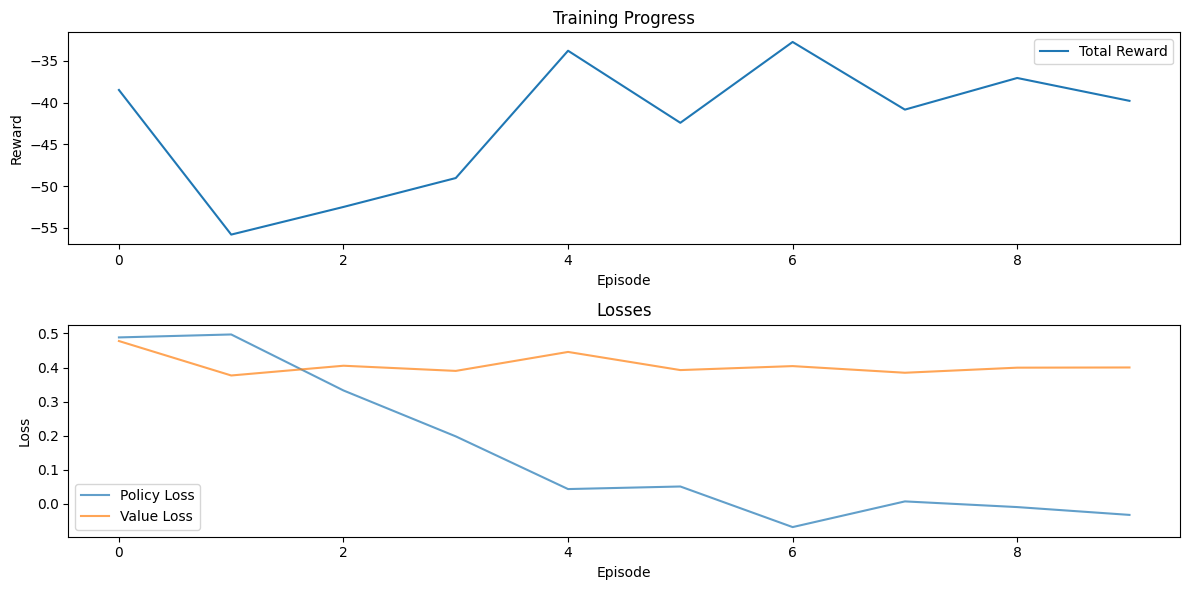

Test Episode: 10, Total Reward: -39.79
Episode: 11, Total Reward: -45.47, Policy Loss: 0.0243, Value Loss: 0.3738
tensor([0.4752, 0.5244, 0.4624], device='cuda:0'), tensor([0.2317, 0.2320, 0.2313], device='cuda:0')
Episode: 12, Total Reward: -32.79, Policy Loss: -0.0934, Value Loss: 0.4001
tensor([0.4848, 0.5435, 0.4549], device='cuda:0'), tensor([0.2275, 0.2274, 0.2349], device='cuda:0')
Episode: 13, Total Reward: -23.03, Policy Loss: -0.1884, Value Loss: 0.4560
tensor([0.4735, 0.5432, 0.4634], device='cuda:0'), tensor([0.2282, 0.2293, 0.2289], device='cuda:0')
Episode: 14, Total Reward: -30.70, Policy Loss: -0.1117, Value Loss: 0.4367
tensor([0.4943, 0.5554, 0.4447], device='cuda:0'), tensor([0.2301, 0.2307, 0.2315], device='cuda:0')
Episode: 15, Total Reward: -36.71, Policy Loss: -0.0757, Value Loss: 0.3957
tensor([0.4795, 0.5549, 0.4343], device='cuda:0'), tensor([0.2222, 0.2340, 0.2291], device='cuda:0')
Episode: 16, Total Reward: -27.85, Policy Loss: -0.1425, Value Loss: 0.4005
t

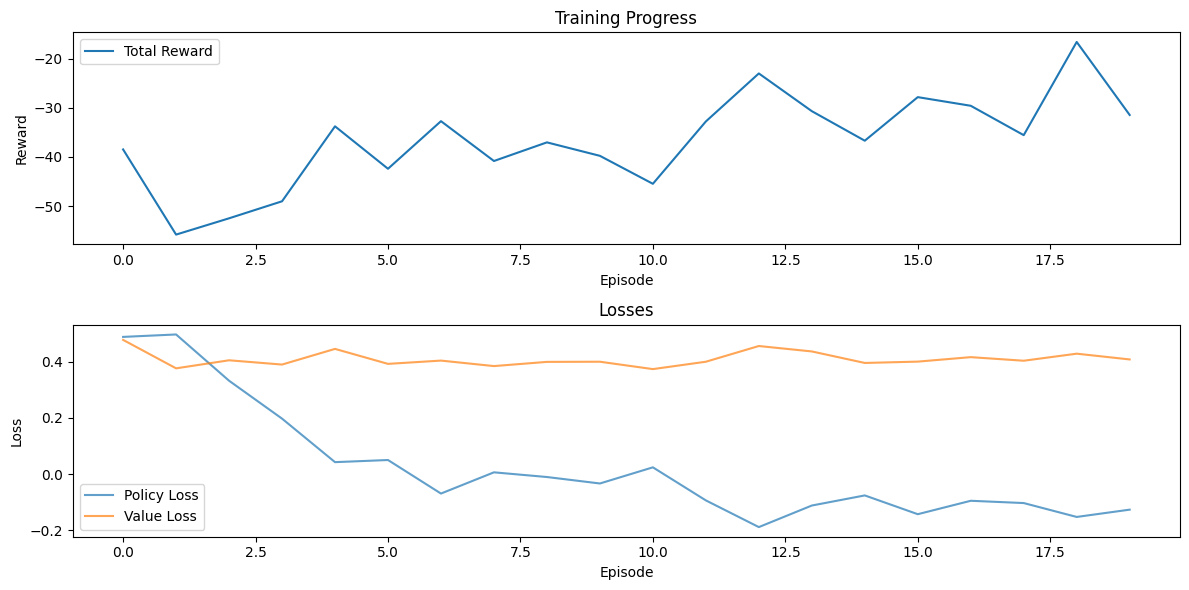

Test Episode: 20, Total Reward: -31.47
Episode: 21, Total Reward: -31.40, Policy Loss: -0.1471, Value Loss: 0.4060
tensor([0.4645, 0.5826, 0.4046], device='cuda:0'), tensor([0.2135, 0.2170, 0.2232], device='cuda:0')
Episode: 22, Total Reward: -17.28, Policy Loss: -0.0151, Value Loss: 0.4019
tensor([0.4752, 0.5774, 0.4115], device='cuda:0'), tensor([0.2194, 0.2245, 0.2203], device='cuda:0')
Episode: 23, Total Reward: -29.81, Policy Loss: -0.1383, Value Loss: 0.3877
tensor([0.4750, 0.5825, 0.3972], device='cuda:0'), tensor([0.2105, 0.2132, 0.2185], device='cuda:0')
Episode: 24, Total Reward: -33.31, Policy Loss: -0.1077, Value Loss: 0.3792
tensor([0.4790, 0.5825, 0.4006], device='cuda:0'), tensor([0.2109, 0.2157, 0.2151], device='cuda:0')
Episode: 25, Total Reward: -30.35, Policy Loss: -0.1303, Value Loss: 0.3668
tensor([0.4889, 0.5885, 0.3930], device='cuda:0'), tensor([0.2133, 0.2138, 0.2089], device='cuda:0')
Episode: 26, Total Reward: -27.45, Policy Loss: -0.0970, Value Loss: 0.3816


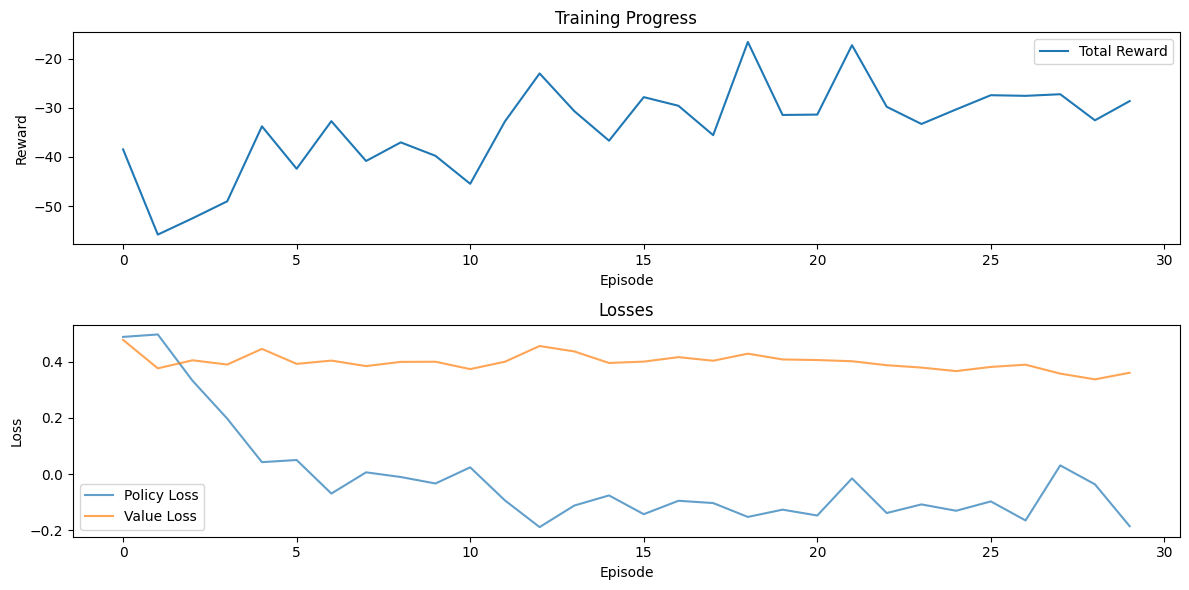

Test Episode: 30, Total Reward: -28.65
Episode: 31, Total Reward: -28.52, Policy Loss: -0.1217, Value Loss: 0.3658
tensor([0.4772, 0.6061, 0.3742], device='cuda:0'), tensor([0.2052, 0.1999, 0.2071], device='cuda:0')
Episode: 32, Total Reward: -29.58, Policy Loss: -0.0804, Value Loss: 0.3782
tensor([0.4667, 0.5969, 0.3811], device='cuda:0'), tensor([0.2057, 0.2033, 0.2025], device='cuda:0')
Episode: 33, Total Reward: -26.99, Policy Loss: 0.0375, Value Loss: 0.3260
tensor([0.4682, 0.6029, 0.3784], device='cuda:0'), tensor([0.2077, 0.2011, 0.2051], device='cuda:0')
Episode: 34, Total Reward: -0.45, Policy Loss: -0.2984, Value Loss: 0.4264
tensor([0.4734, 0.6145, 0.3644], device='cuda:0'), tensor([0.2033, 0.1998, 0.1961], device='cuda:0')
Episode: 35, Total Reward: -2.61, Policy Loss: -0.1949, Value Loss: 0.4159
tensor([0.4819, 0.6175, 0.3841], device='cuda:0'), tensor([0.2055, 0.2007, 0.1991], device='cuda:0')
Episode: 36, Total Reward: 1.76, Policy Loss: -0.3107, Value Loss: 0.4358
tenso

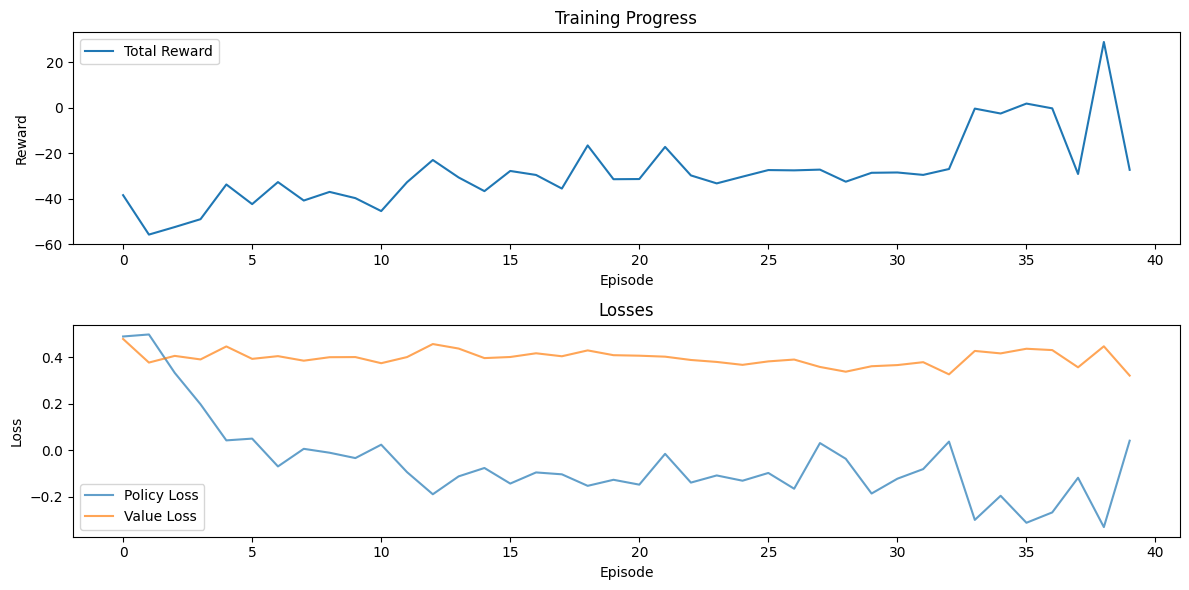

Test Episode: 40, Total Reward: -27.34
Episode: 41, Total Reward: -25.49, Policy Loss: 0.0240, Value Loss: 0.3244
tensor([0.4963, 0.6316, 0.3539], device='cuda:0'), tensor([0.1903, 0.1833, 0.1887], device='cuda:0')
Episode: 42, Total Reward: -30.64, Policy Loss: 0.0305, Value Loss: 0.3100
tensor([0.4950, 0.6370, 0.3429], device='cuda:0'), tensor([0.1927, 0.1850, 0.1844], device='cuda:0')
Episode: 43, Total Reward: 16.50, Policy Loss: -0.2248, Value Loss: 0.4129
tensor([0.4907, 0.6351, 0.3319], device='cuda:0'), tensor([0.1953, 0.1848, 0.1804], device='cuda:0')
Episode: 44, Total Reward: -0.02, Policy Loss: -0.1174, Value Loss: 0.3838
tensor([0.4874, 0.6370, 0.3367], device='cuda:0'), tensor([0.1929, 0.1876, 0.1839], device='cuda:0')
Episode: 45, Total Reward: 83.57, Policy Loss: -0.6635, Value Loss: 0.5979
tensor([0.4793, 0.6427, 0.3420], device='cuda:0'), tensor([0.1865, 0.1833, 0.1866], device='cuda:0')
Episode: 46, Total Reward: 27.19, Policy Loss: -0.2620, Value Loss: 0.4261
tensor

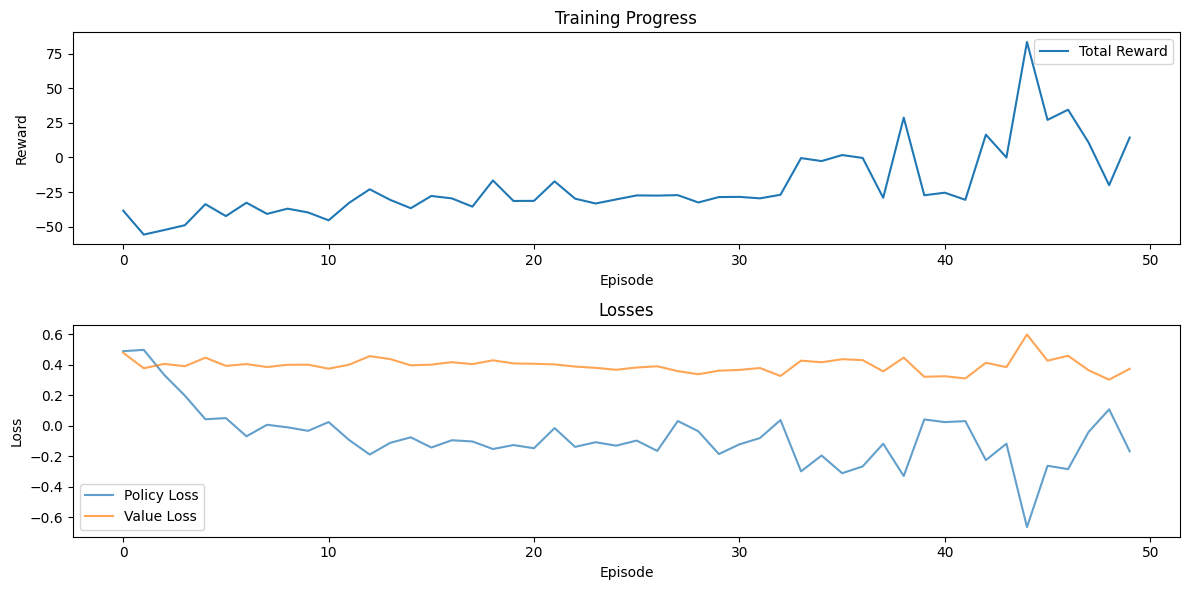

Test Episode: 50, Total Reward: 14.41
Episode: 51, Total Reward: 66.08, Policy Loss: -0.3634, Value Loss: 0.4866
tensor([0.4720, 0.6686, 0.3057], device='cuda:0'), tensor([0.1745, 0.1629, 0.1613], device='cuda:0')
Episode: 52, Total Reward: 50.54, Policy Loss: -0.3224, Value Loss: 0.4203
tensor([0.4800, 0.6710, 0.2939], device='cuda:0'), tensor([0.1722, 0.1625, 0.1527], device='cuda:0')
Episode: 53, Total Reward: 16.75, Policy Loss: 0.0038, Value Loss: 0.3147
tensor([0.4797, 0.6669, 0.2985], device='cuda:0'), tensor([0.1689, 0.1640, 0.1568], device='cuda:0')
Episode: 54, Total Reward: 49.25, Policy Loss: -0.3433, Value Loss: 0.3673
tensor([0.4801, 0.6697, 0.3007], device='cuda:0'), tensor([0.1702, 0.1539, 0.1509], device='cuda:0')
Episode: 55, Total Reward: 72.17, Policy Loss: -0.2842, Value Loss: 0.4084
tensor([0.4861, 0.6729, 0.2874], device='cuda:0'), tensor([0.1647, 0.1529, 0.1413], device='cuda:0')
Episode: 56, Total Reward: 20.03, Policy Loss: 0.0384, Value Loss: 0.3366
tensor([0

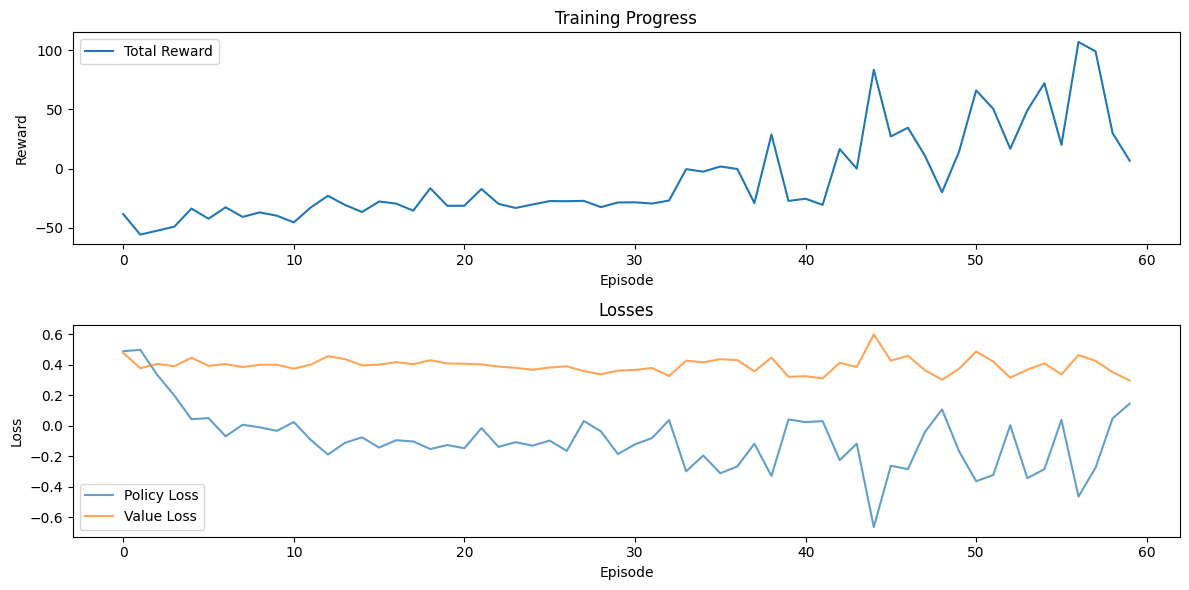

Test Episode: 60, Total Reward: 6.68
Episode: 61, Total Reward: 26.61, Policy Loss: 0.0088, Value Loss: 0.3608
tensor([0.4817, 0.6642, 0.2953], device='cuda:0'), tensor([0.1655, 0.1567, 0.1454], device='cuda:0')
Episode: 62, Total Reward: 50.26, Policy Loss: -0.2871, Value Loss: 0.4007
tensor([0.4859, 0.6614, 0.2934], device='cuda:0'), tensor([0.1660, 0.1523, 0.1422], device='cuda:0')
Episode: 63, Total Reward: 63.56, Policy Loss: -0.3832, Value Loss: 0.4037
tensor([0.4868, 0.6707, 0.2942], device='cuda:0'), tensor([0.1625, 0.1453, 0.1458], device='cuda:0')
Episode: 64, Total Reward: 36.22, Policy Loss: 0.0642, Value Loss: 0.3380
tensor([0.4885, 0.6693, 0.2944], device='cuda:0'), tensor([0.1533, 0.1434, 0.1377], device='cuda:0')
Episode: 65, Total Reward: 6.50, Policy Loss: 0.0775, Value Loss: 0.2484
tensor([0.4848, 0.6715, 0.2930], device='cuda:0'), tensor([0.1607, 0.1497, 0.1341], device='cuda:0')
Episode: 66, Total Reward: 17.92, Policy Loss: 0.0037, Value Loss: 0.2843
tensor([0.482

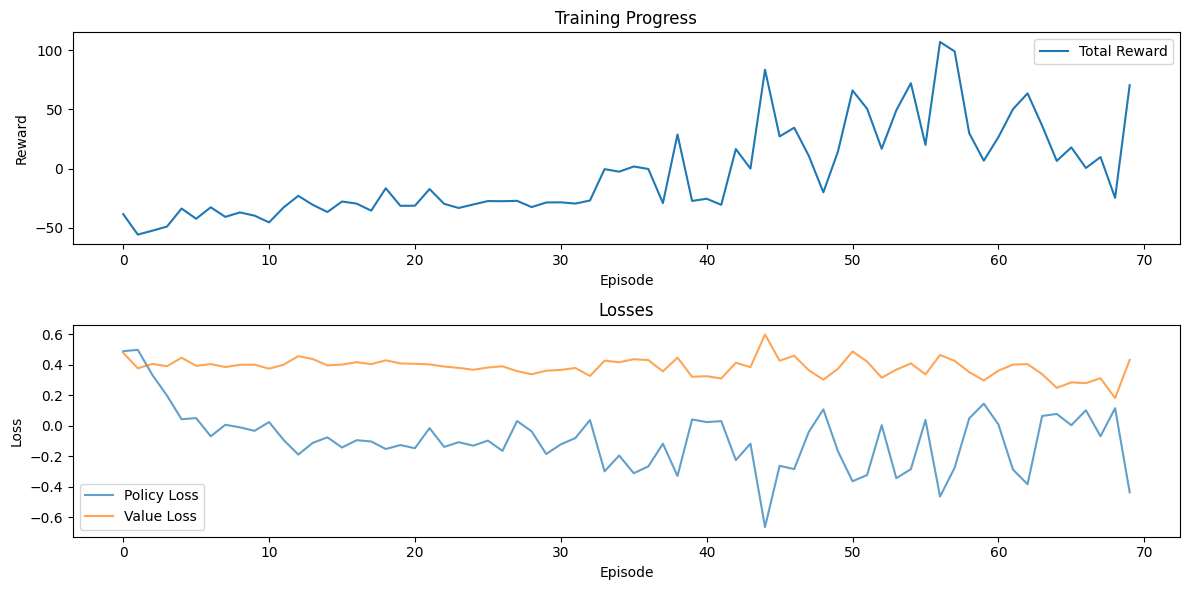

Test Episode: 70, Total Reward: 70.53
Episode: 71, Total Reward: 8.07, Policy Loss: -0.0517, Value Loss: 0.2552
tensor([0.4757, 0.6777, 0.2891], device='cuda:0'), tensor([0.1526, 0.1428, 0.1315], device='cuda:0')
Episode: 72, Total Reward: 21.91, Policy Loss: -0.1345, Value Loss: 0.3710
tensor([0.4769, 0.6809, 0.2842], device='cuda:0'), tensor([0.1491, 0.1371, 0.1321], device='cuda:0')
Episode: 73, Total Reward: 46.81, Policy Loss: -0.1750, Value Loss: 0.3182
tensor([0.4663, 0.6839, 0.2867], device='cuda:0'), tensor([0.1448, 0.1371, 0.1312], device='cuda:0')
Episode: 74, Total Reward: 68.50, Policy Loss: -0.3093, Value Loss: 0.4009
tensor([0.4758, 0.6919, 0.2880], device='cuda:0'), tensor([0.1474, 0.1314, 0.1301], device='cuda:0')
Episode: 75, Total Reward: -22.73, Policy Loss: 0.4176, Value Loss: 0.2194
tensor([0.4724, 0.6843, 0.2890], device='cuda:0'), tensor([0.1489, 0.1387, 0.1329], device='cuda:0')
Episode: 76, Total Reward: 86.05, Policy Loss: -0.2911, Value Loss: 0.3600
tensor([

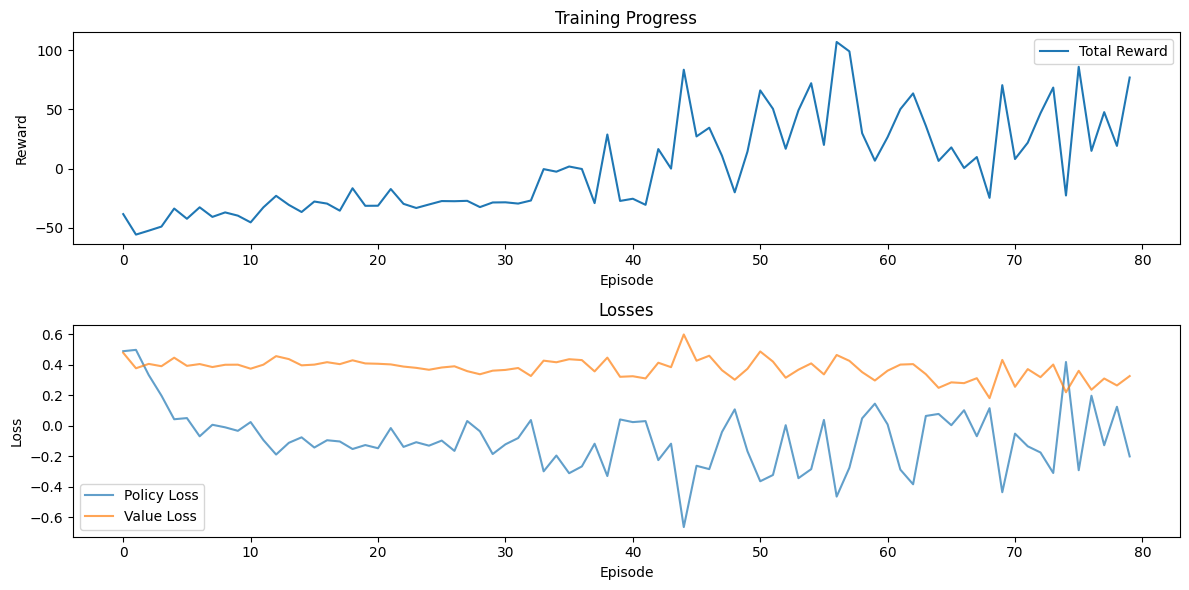

Test Episode: 80, Total Reward: 76.97
Episode: 81, Total Reward: 88.66, Policy Loss: -0.1412, Value Loss: 0.3336
tensor([0.4694, 0.6931, 0.2666], device='cuda:0'), tensor([0.1431, 0.1323, 0.1244], device='cuda:0')
Episode: 82, Total Reward: 88.79, Policy Loss: -0.3580, Value Loss: 0.3969
tensor([0.4743, 0.6898, 0.2669], device='cuda:0'), tensor([0.1433, 0.1317, 0.1264], device='cuda:0')
Episode: 83, Total Reward: 78.80, Policy Loss: -0.1853, Value Loss: 0.3686
tensor([0.4699, 0.6948, 0.2564], device='cuda:0'), tensor([0.1401, 0.1282, 0.1217], device='cuda:0')
Episode: 84, Total Reward: 56.12, Policy Loss: -0.2106, Value Loss: 0.3002
tensor([0.4692, 0.6859, 0.2603], device='cuda:0'), tensor([0.1363, 0.1281, 0.1217], device='cuda:0')
Episode: 85, Total Reward: 27.62, Policy Loss: -0.0163, Value Loss: 0.2925
tensor([0.4723, 0.6852, 0.2667], device='cuda:0'), tensor([0.1440, 0.1304, 0.1284], device='cuda:0')
Episode: 86, Total Reward: 61.40, Policy Loss: -0.1076, Value Loss: 0.2866
tensor(

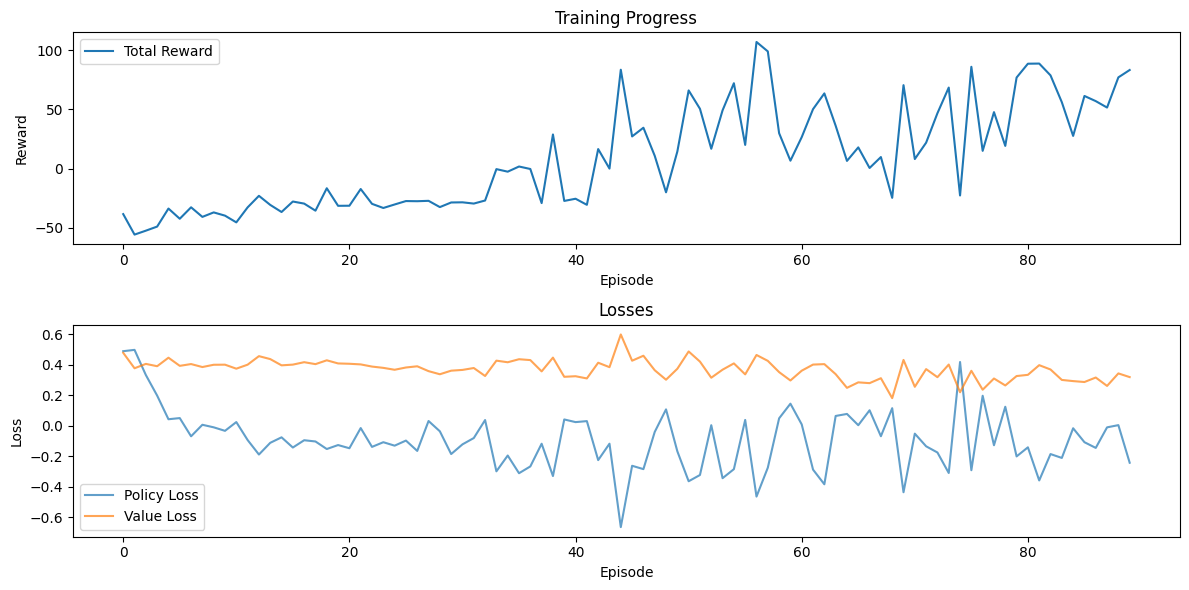

Test Episode: 90, Total Reward: 83.34
Episode: 91, Total Reward: 77.84, Policy Loss: -0.1177, Value Loss: 0.3151
tensor([0.4717, 0.6896, 0.2472], device='cuda:0'), tensor([0.1367, 0.1182, 0.1180], device='cuda:0')
Episode: 92, Total Reward: 58.87, Policy Loss: -0.1873, Value Loss: 0.2692
tensor([0.4790, 0.6889, 0.2533], device='cuda:0'), tensor([0.1337, 0.1144, 0.1169], device='cuda:0')
Episode: 93, Total Reward: 54.26, Policy Loss: 0.0554, Value Loss: 0.2334
tensor([0.4713, 0.6904, 0.2462], device='cuda:0'), tensor([0.1315, 0.1141, 0.1161], device='cuda:0')
Episode: 94, Total Reward: 18.49, Policy Loss: 0.2598, Value Loss: 0.2112
tensor([0.4761, 0.6775, 0.2596], device='cuda:0'), tensor([0.1372, 0.1223, 0.1214], device='cuda:0')
Episode: 95, Total Reward: 46.26, Policy Loss: 0.0797, Value Loss: 0.2099
tensor([0.4677, 0.6833, 0.2525], device='cuda:0'), tensor([0.1255, 0.1140, 0.1198], device='cuda:0')
Episode: 96, Total Reward: 83.57, Policy Loss: -0.0795, Value Loss: 0.2922
tensor([0.

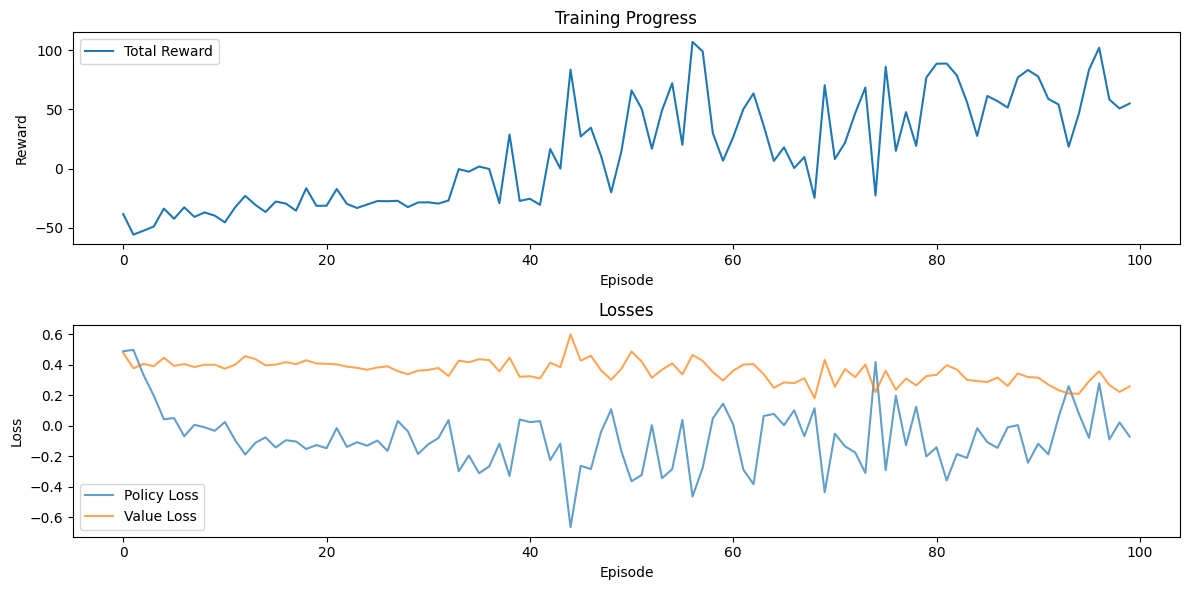

Test Episode: 100, Total Reward: 55.05
Episode: 101, Total Reward: 68.14, Policy Loss: -0.1644, Value Loss: 0.3087
tensor([0.4581, 0.6961, 0.2409], device='cuda:0'), tensor([0.1312, 0.1106, 0.1052], device='cuda:0')
Episode: 102, Total Reward: 58.51, Policy Loss: -0.0689, Value Loss: 0.2255
tensor([0.4582, 0.6973, 0.2388], device='cuda:0'), tensor([0.1208, 0.1109, 0.1088], device='cuda:0')
Episode: 103, Total Reward: 72.32, Policy Loss: -0.1402, Value Loss: 0.2762
tensor([0.4562, 0.6927, 0.2334], device='cuda:0'), tensor([0.1191, 0.1112, 0.1078], device='cuda:0')
Episode: 104, Total Reward: 28.48, Policy Loss: 0.2086, Value Loss: 0.2753
tensor([0.4627, 0.6870, 0.2415], device='cuda:0'), tensor([0.1265, 0.1132, 0.1126], device='cuda:0')
Episode: 105, Total Reward: 93.35, Policy Loss: -0.2319, Value Loss: 0.3236
tensor([0.4679, 0.6947, 0.2288], device='cuda:0'), tensor([0.1255, 0.1095, 0.1092], device='cuda:0')
Episode: 106, Total Reward: 84.81, Policy Loss: 0.8352, Value Loss: 1.1594
te

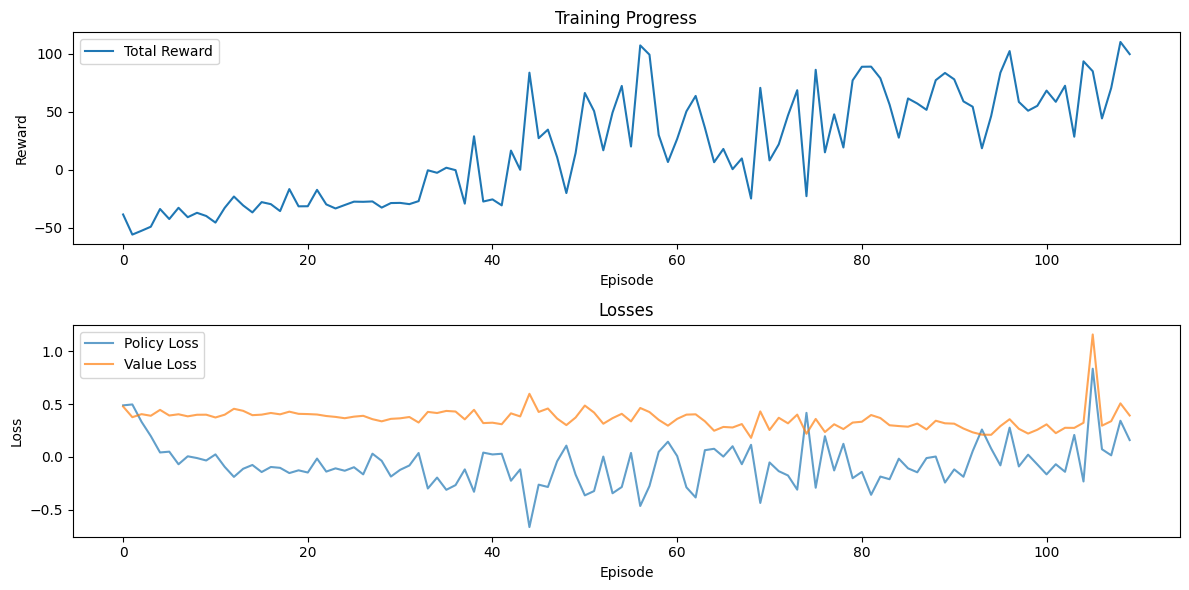

Test Episode: 110, Total Reward: 99.53
Episode: 111, Total Reward: 80.88, Policy Loss: -0.0069, Value Loss: 0.3259
tensor([0.4510, 0.6913, 0.2307], device='cuda:0'), tensor([0.1145, 0.1087, 0.1070], device='cuda:0')
Episode: 112, Total Reward: 92.73, Policy Loss: 0.0687, Value Loss: 0.3759
tensor([0.4582, 0.6951, 0.2290], device='cuda:0'), tensor([0.1212, 0.1105, 0.0995], device='cuda:0')
Episode: 113, Total Reward: 88.64, Policy Loss: 0.1032, Value Loss: 0.3393
tensor([0.4554, 0.6936, 0.2270], device='cuda:0'), tensor([0.1175, 0.1074, 0.1035], device='cuda:0')
Episode: 114, Total Reward: 72.34, Policy Loss: 0.3985, Value Loss: 0.3370
tensor([0.4606, 0.7023, 0.2229], device='cuda:0'), tensor([0.1114, 0.1061, 0.1024], device='cuda:0')
Episode: 115, Total Reward: 115.75, Policy Loss: -0.1806, Value Loss: 0.3338
tensor([0.4550, 0.6985, 0.2225], device='cuda:0'), tensor([0.1141, 0.1092, 0.1015], device='cuda:0')
Episode: 116, Total Reward: 99.33, Policy Loss: -0.0535, Value Loss: 0.3965
te

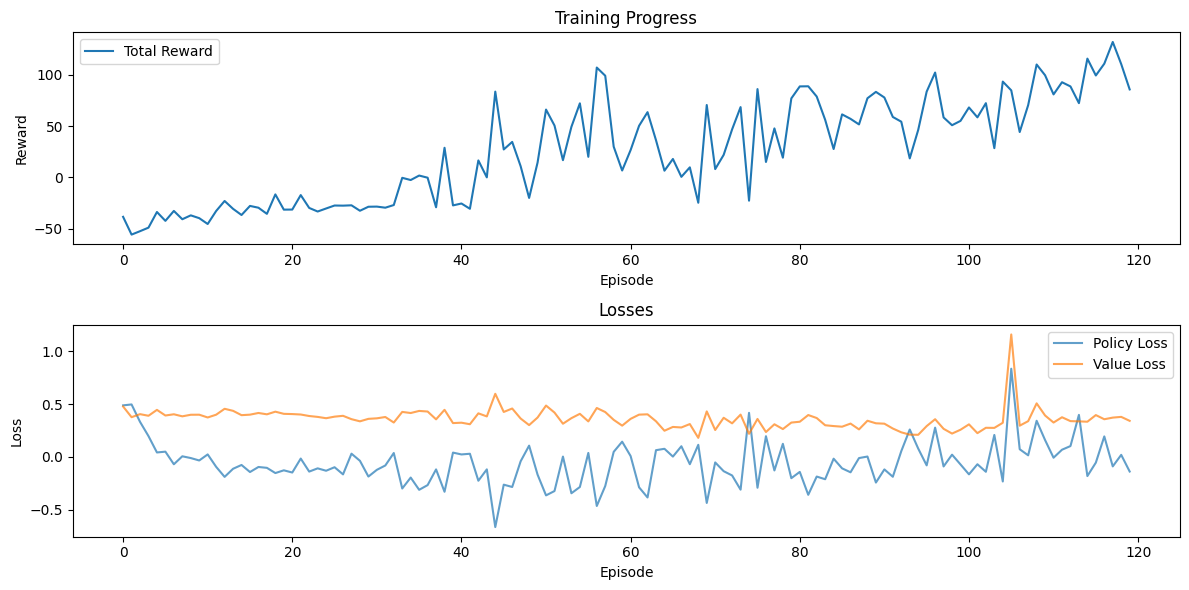

Test Episode: 120, Total Reward: 85.73
Episode: 121, Total Reward: 109.21, Policy Loss: -0.1522, Value Loss: 0.3405
tensor([0.4609, 0.6951, 0.2212], device='cuda:0'), tensor([0.1132, 0.1066, 0.1012], device='cuda:0')
Episode: 122, Total Reward: 117.98, Policy Loss: -0.2059, Value Loss: 0.3858
tensor([0.4648, 0.6966, 0.2153], device='cuda:0'), tensor([0.1106, 0.1072, 0.1002], device='cuda:0')
Episode: 123, Total Reward: 133.33, Policy Loss: -0.3387, Value Loss: 0.3927
tensor([0.4632, 0.6966, 0.2216], device='cuda:0'), tensor([0.1133, 0.1008, 0.1002], device='cuda:0')
Episode: 124, Total Reward: 91.53, Policy Loss: 0.0235, Value Loss: 0.3086
tensor([0.4650, 0.6937, 0.2238], device='cuda:0'), tensor([0.1156, 0.1092, 0.1042], device='cuda:0')
Episode: 125, Total Reward: 167.79, Policy Loss: -0.5522, Value Loss: 0.4010
tensor([0.4585, 0.7009, 0.2203], device='cuda:0'), tensor([0.1101, 0.1056, 0.1020], device='cuda:0')
Episode: 126, Total Reward: 128.63, Policy Loss: -0.2949, Value Loss: 0.3

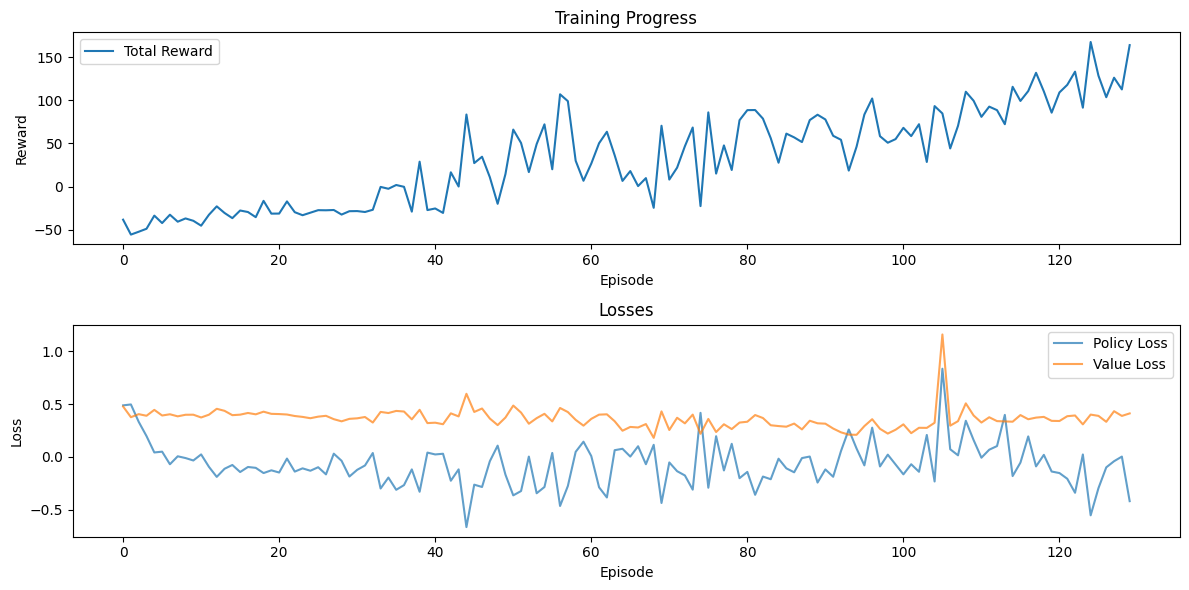

Test Episode: 130, Total Reward: 164.13
Episode: 131, Total Reward: 139.33, Policy Loss: -0.1003, Value Loss: 0.3894
tensor([0.4651, 0.7036, 0.2208], device='cuda:0'), tensor([0.1065, 0.1056, 0.1019], device='cuda:0')
Episode: 132, Total Reward: 124.18, Policy Loss: 0.0518, Value Loss: 0.3567
tensor([0.4678, 0.7066, 0.2219], device='cuda:0'), tensor([0.1041, 0.1032, 0.1005], device='cuda:0')
Episode: 133, Total Reward: 169.44, Policy Loss: -0.2574, Value Loss: 0.4094
tensor([0.4665, 0.7080, 0.2168], device='cuda:0'), tensor([0.1033, 0.1021, 0.0977], device='cuda:0')
Episode: 134, Total Reward: 157.48, Policy Loss: -0.2706, Value Loss: 0.4664
tensor([0.4617, 0.7059, 0.2178], device='cuda:0'), tensor([0.1057, 0.0964, 0.0940], device='cuda:0')
Episode: 135, Total Reward: 140.73, Policy Loss: 0.0004, Value Loss: 0.3375
tensor([0.4640, 0.7142, 0.2197], device='cuda:0'), tensor([0.1035, 0.0921, 0.0982], device='cuda:0')
Episode: 136, Total Reward: 174.02, Policy Loss: -0.1890, Value Loss: 0.

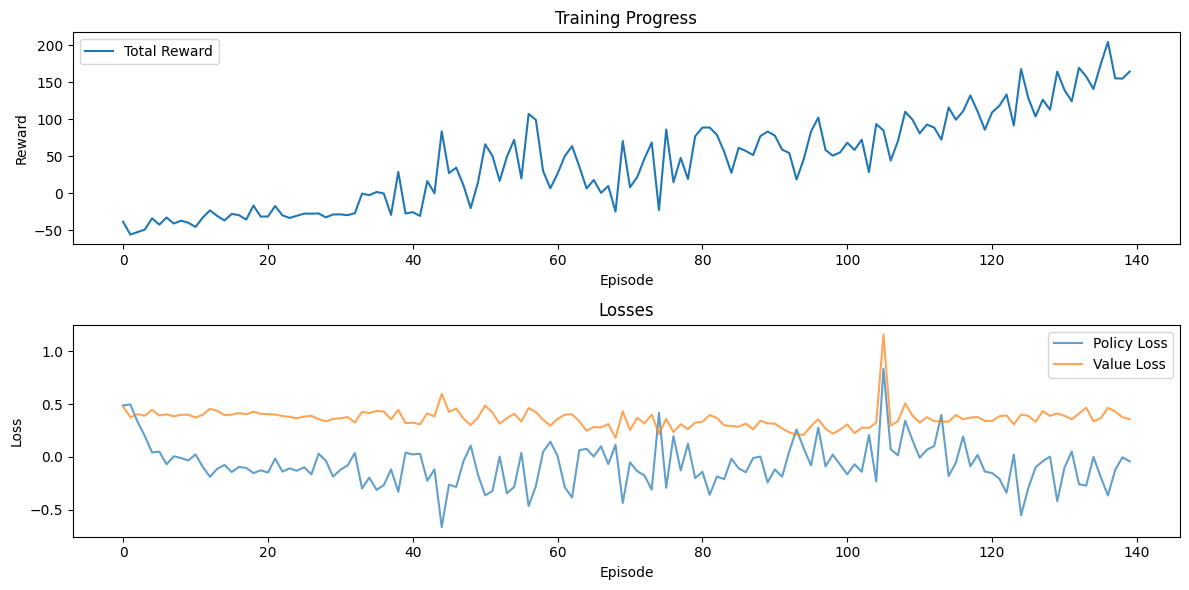

Test Episode: 140, Total Reward: 164.30
Episode: 141, Total Reward: 193.54, Policy Loss: -0.3153, Value Loss: 0.3898
tensor([0.4694, 0.7108, 0.2115], device='cuda:0'), tensor([0.0978, 0.0879, 0.0882], device='cuda:0')
Episode: 142, Total Reward: 173.12, Policy Loss: -0.3370, Value Loss: 0.4125
tensor([0.4714, 0.7086, 0.2120], device='cuda:0'), tensor([0.0986, 0.0910, 0.0856], device='cuda:0')
Episode: 143, Total Reward: 216.25, Policy Loss: -0.4000, Value Loss: 0.4739
tensor([0.4722, 0.7115, 0.2135], device='cuda:0'), tensor([0.1036, 0.0942, 0.0942], device='cuda:0')
Episode: 144, Total Reward: 251.57, Policy Loss: -0.3993, Value Loss: 0.4285
tensor([0.4662, 0.7108, 0.2053], device='cuda:0'), tensor([0.0956, 0.0881, 0.0860], device='cuda:0')
Episode: 145, Total Reward: 262.25, Policy Loss: -0.0554, Value Loss: 1.3214
tensor([0.4678, 0.7106, 0.2182], device='cuda:0'), tensor([0.1066, 0.0934, 0.1156], device='cuda:0')
Episode: 146, Total Reward: 171.66, Policy Loss: 0.3138, Value Loss: 0

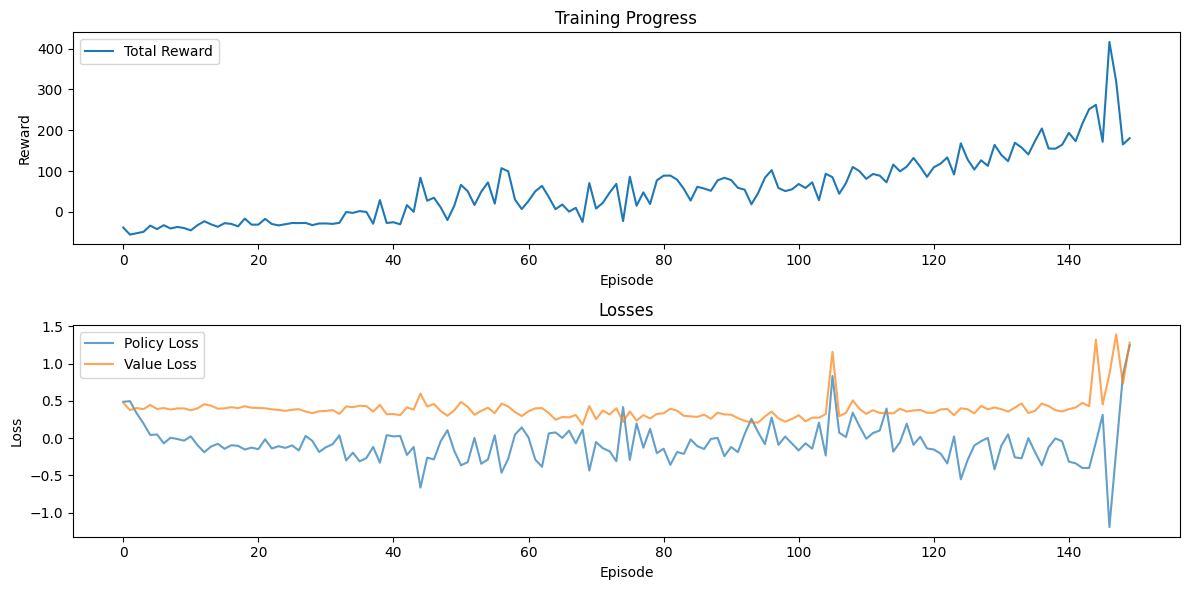

Test Episode: 150, Total Reward: 180.60
Episode: 151, Total Reward: 191.31, Policy Loss: 0.4240, Value Loss: 1.0358
tensor([0.4603, 0.7022, 0.2229], device='cuda:0'), tensor([0.1184, 0.1184, 0.1200], device='cuda:0')
Episode: 152, Total Reward: 204.86, Policy Loss: -0.0816, Value Loss: 0.6889
tensor([0.4723, 0.7118, 0.2178], device='cuda:0'), tensor([0.1066, 0.0963, 0.0992], device='cuda:0')
Episode: 153, Total Reward: 191.08, Policy Loss: -0.0296, Value Loss: 0.7683
tensor([0.4611, 0.7106, 0.2425], device='cuda:0'), tensor([0.1387, 0.1409, 0.1520], device='cuda:0')
Episode: 154, Total Reward: 607.13, Policy Loss: -1.8723, Value Loss: 1.1710
tensor([0.4749, 0.7287, 0.1851], device='cuda:0'), tensor([0.0900, 0.0905, 0.0878], device='cuda:0')
Episode: 155, Total Reward: 260.12, Policy Loss: 0.4192, Value Loss: 0.9822
tensor([0.4154, 0.6635, 0.2838], device='cuda:0'), tensor([0.1587, 0.1919, 0.2103], device='cuda:0')
Episode: 156, Total Reward: 702.99, Policy Loss: -1.9064, Value Loss: 1.

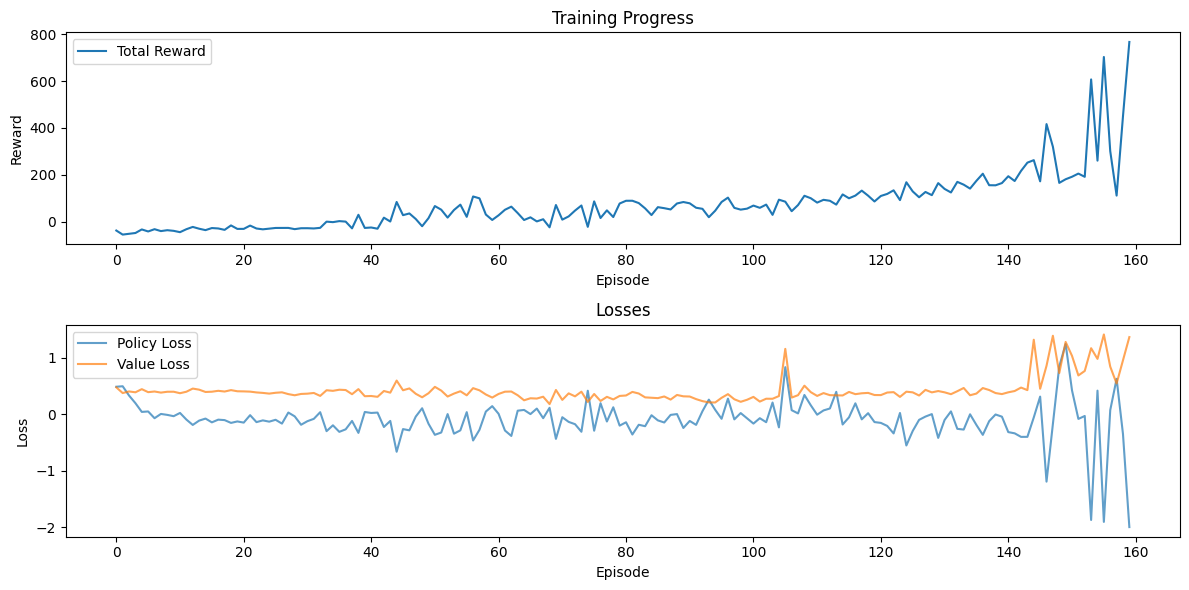

Test Episode: 160, Total Reward: 767.14
Episode: 161, Total Reward: 203.84, Policy Loss: 1.6107, Value Loss: 1.3914
tensor([0.4201, 0.6715, 0.3259], device='cuda:0'), tensor([0.1770, 0.2000, 0.2504], device='cuda:0')
Episode: 162, Total Reward: 394.75, Policy Loss: 0.1808, Value Loss: 0.9738
tensor([0.4325, 0.6887, 0.2671], device='cuda:0'), tensor([0.1453, 0.1603, 0.2159], device='cuda:0')
Episode: 163, Total Reward: 364.58, Policy Loss: 0.4177, Value Loss: 1.0989
tensor([0.4243, 0.6812, 0.2878], device='cuda:0'), tensor([0.1593, 0.1857, 0.2353], device='cuda:0')
Episode: 164, Total Reward: 488.93, Policy Loss: 0.0078, Value Loss: 1.1277
tensor([0.4562, 0.7103, 0.2033], device='cuda:0'), tensor([0.1151, 0.1168, 0.1253], device='cuda:0')
Episode: 165, Total Reward: 164.65, Policy Loss: 0.9264, Value Loss: 0.8564
tensor([0.4042, 0.6624, 0.2878], device='cuda:0'), tensor([0.1512, 0.1796, 0.2239], device='cuda:0')
Episode: 166, Total Reward: 178.84, Policy Loss: 0.7478, Value Loss: 0.8318

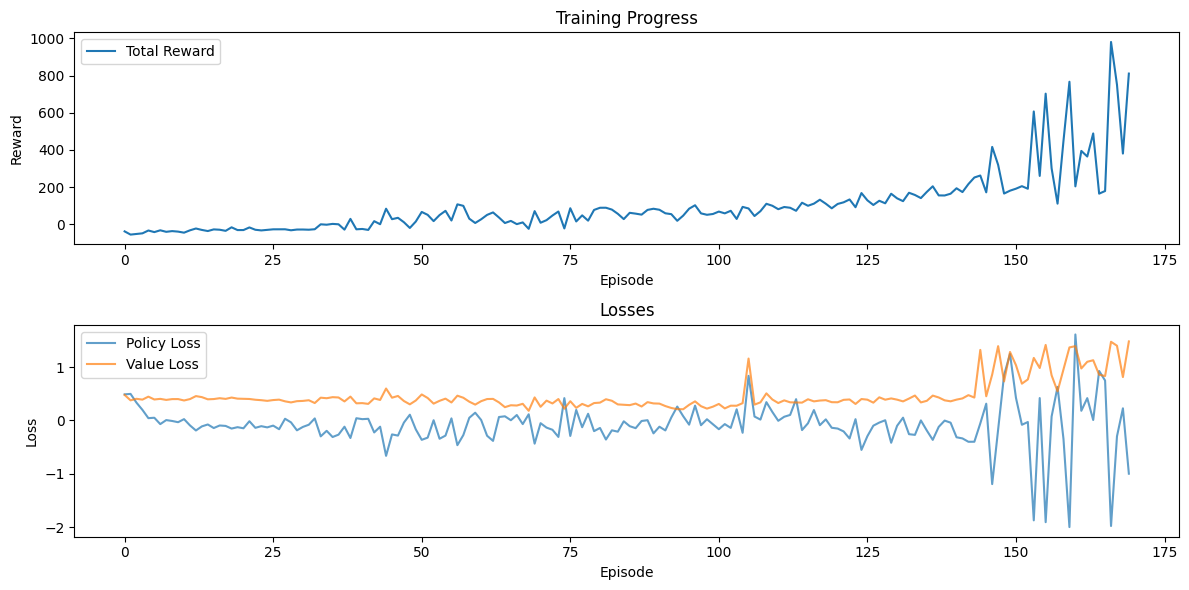

Test Episode: 170, Total Reward: 811.09
Episode: 171, Total Reward: 497.05, Policy Loss: -0.2579, Value Loss: 1.0876
tensor([0.4678, 0.7178, 0.1982], device='cuda:0'), tensor([0.1009, 0.0975, 0.0879], device='cuda:0')
Episode: 172, Total Reward: 1030.23, Policy Loss: -1.8121, Value Loss: 1.2654
tensor([0.4852, 0.7459, 0.1664], device='cuda:0'), tensor([0.0776, 0.0662, 0.0615], device='cuda:0')
Episode: 173, Total Reward: 529.49, Policy Loss: 0.4239, Value Loss: 1.1256
tensor([0.3885, 0.6554, 0.3293], device='cuda:0'), tensor([0.1753, 0.2054, 0.2752], device='cuda:0')
Episode: 174, Total Reward: 123.07, Policy Loss: 1.7441, Value Loss: 0.8551
tensor([0.4567, 0.7122, 0.2176], device='cuda:0'), tensor([0.1078, 0.1010, 0.0950], device='cuda:0')
Episode: 175, Total Reward: 713.54, Policy Loss: -0.3489, Value Loss: 1.2941
tensor([0.4819, 0.7394, 0.1771], device='cuda:0'), tensor([0.0855, 0.0739, 0.0583], device='cuda:0')
Episode: 176, Total Reward: 204.67, Policy Loss: 1.5856, Value Loss: 0.

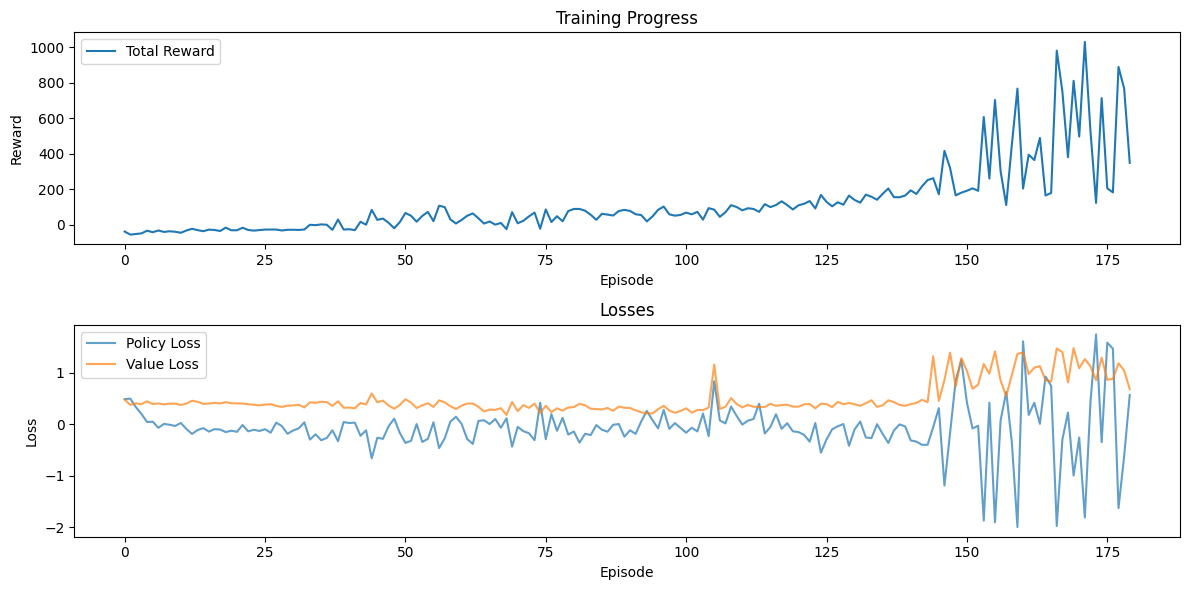

Test Episode: 180, Total Reward: 348.63
Episode: 181, Total Reward: 208.70, Policy Loss: 0.9587, Value Loss: 0.6328
tensor([0.3830, 0.6556, 0.2880], device='cuda:0'), tensor([0.1590, 0.1854, 0.2144], device='cuda:0')
Episode: 182, Total Reward: 476.09, Policy Loss: 0.0591, Value Loss: 0.8184
tensor([0.3992, 0.6603, 0.2771], device='cuda:0'), tensor([0.1583, 0.1976, 0.2229], device='cuda:0')
Episode: 183, Total Reward: 1052.49, Policy Loss: -1.5469, Value Loss: 1.6150
tensor([0.4855, 0.7465, 0.1571], device='cuda:0'), tensor([0.0761, 0.0658, 0.0511], device='cuda:0')
Episode: 184, Total Reward: 685.67, Policy Loss: -0.6905, Value Loss: 1.2702
tensor([0.4504, 0.7067, 0.1865], device='cuda:0'), tensor([0.1127, 0.1223, 0.1031], device='cuda:0')
Episode: 185, Total Reward: 876.41, Policy Loss: -0.9109, Value Loss: 1.7945
tensor([0.4784, 0.7377, 0.1599], device='cuda:0'), tensor([0.0866, 0.0727, 0.0562], device='cuda:0')
Episode: 186, Total Reward: 557.17, Policy Loss: -0.7366, Value Loss: 1

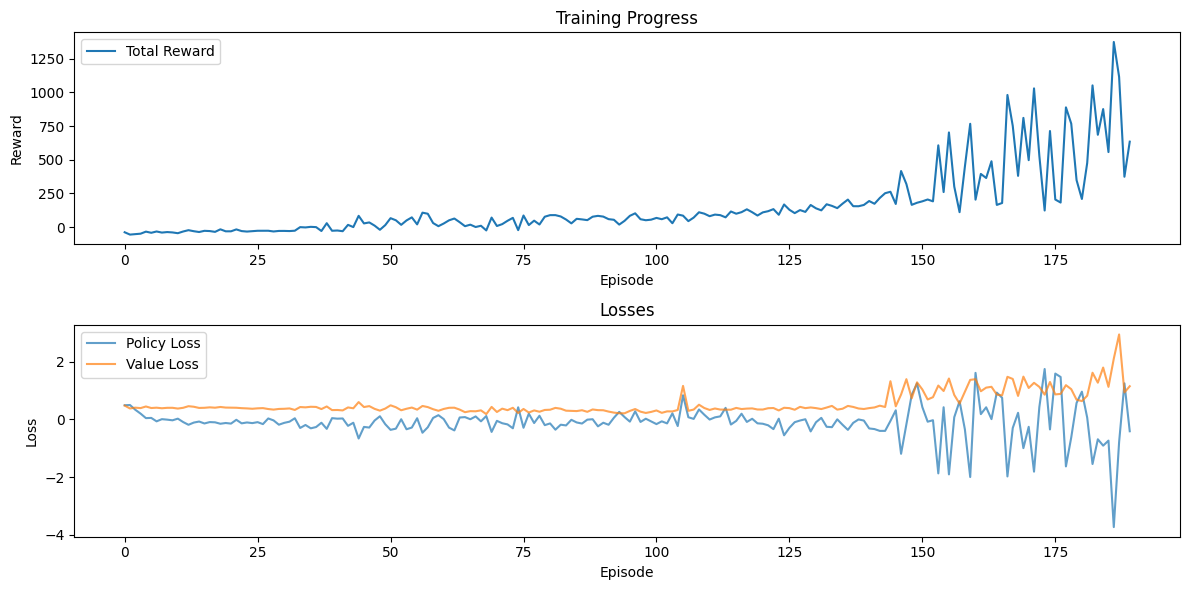

Test Episode: 190, Total Reward: 634.52
Episode: 191, Total Reward: 1340.06, Policy Loss: -0.9614, Value Loss: 2.8666
tensor([0.4830, 0.7400, 0.1331], device='cuda:0'), tensor([0.0700, 0.0543, 0.0377], device='cuda:0')
Episode: 192, Total Reward: 227.92, Policy Loss: 0.7480, Value Loss: 0.5145
tensor([0.4216, 0.6904, 0.1915], device='cuda:0'), tensor([0.1120, 0.0991, 0.1044], device='cuda:0')
Episode: 193, Total Reward: 606.15, Policy Loss: 0.7318, Value Loss: 1.2077
tensor([0.4234, 0.6952, 0.2002], device='cuda:0'), tensor([0.1377, 0.1357, 0.1620], device='cuda:0')
Episode: 194, Total Reward: 754.89, Policy Loss: -0.1393, Value Loss: 1.6085
tensor([0.4568, 0.7160, 0.1567], device='cuda:0'), tensor([0.0939, 0.0798, 0.0710], device='cuda:0')
Episode: 195, Total Reward: 704.10, Policy Loss: 0.5512, Value Loss: 1.5810
tensor([0.4557, 0.7157, 0.1550], device='cuda:0'), tensor([0.0954, 0.0841, 0.0677], device='cuda:0')
Episode: 196, Total Reward: 549.94, Policy Loss: 1.1962, Value Loss: 1.4

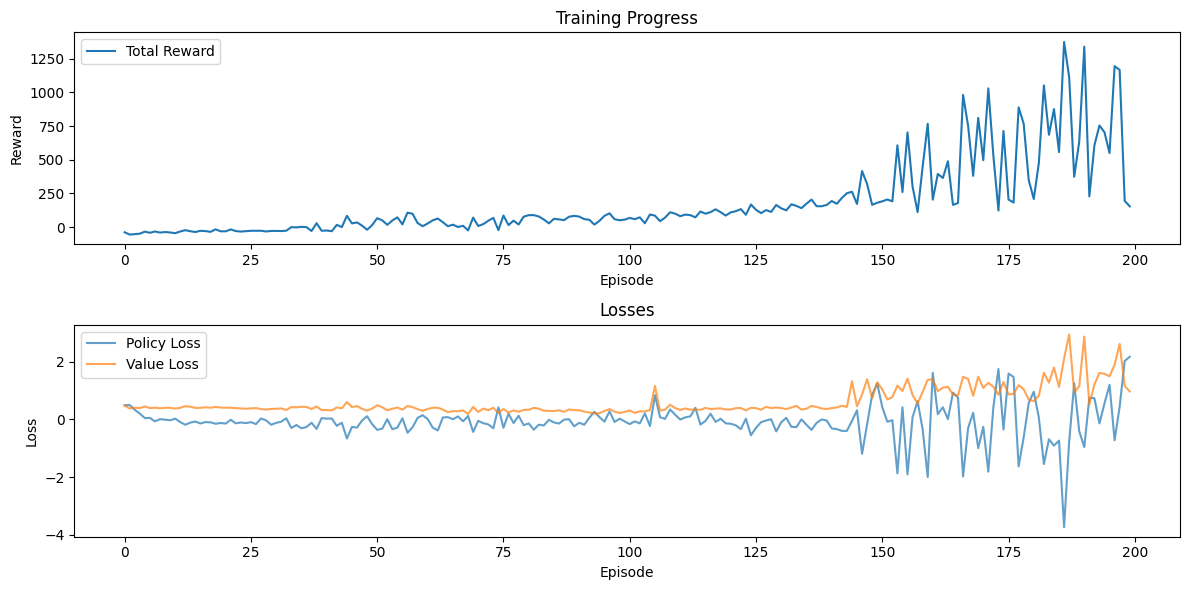

Test Episode: 200, Total Reward: 154.05
Episode: 201, Total Reward: 1274.18, Policy Loss: -0.8959, Value Loss: 2.1226
tensor([0.4798, 0.7354, 0.1350], device='cuda:0'), tensor([0.0761, 0.0603, 0.0518], device='cuda:0')
Episode: 202, Total Reward: 1293.00, Policy Loss: -0.8372, Value Loss: 2.7359
tensor([0.4788, 0.7379, 0.1382], device='cuda:0'), tensor([0.0775, 0.0611, 0.0499], device='cuda:0')
Episode: 203, Total Reward: 920.49, Policy Loss: 0.9503, Value Loss: 2.8348
tensor([0.4653, 0.7297, 0.1463], device='cuda:0'), tensor([0.0848, 0.0670, 0.0534], device='cuda:0')
Episode: 204, Total Reward: 1204.85, Policy Loss: 0.1158, Value Loss: 1.5636
tensor([0.4725, 0.7362, 0.1466], device='cuda:0'), tensor([0.0763, 0.0591, 0.0553], device='cuda:0')
Episode: 205, Total Reward: 564.25, Policy Loss: 2.0417, Value Loss: 1.3323
tensor([0.4257, 0.6963, 0.2219], device='cuda:0'), tensor([0.1465, 0.1485, 0.1854], device='cuda:0')
Episode: 206, Total Reward: 773.16, Policy Loss: -0.5238, Value Loss: 

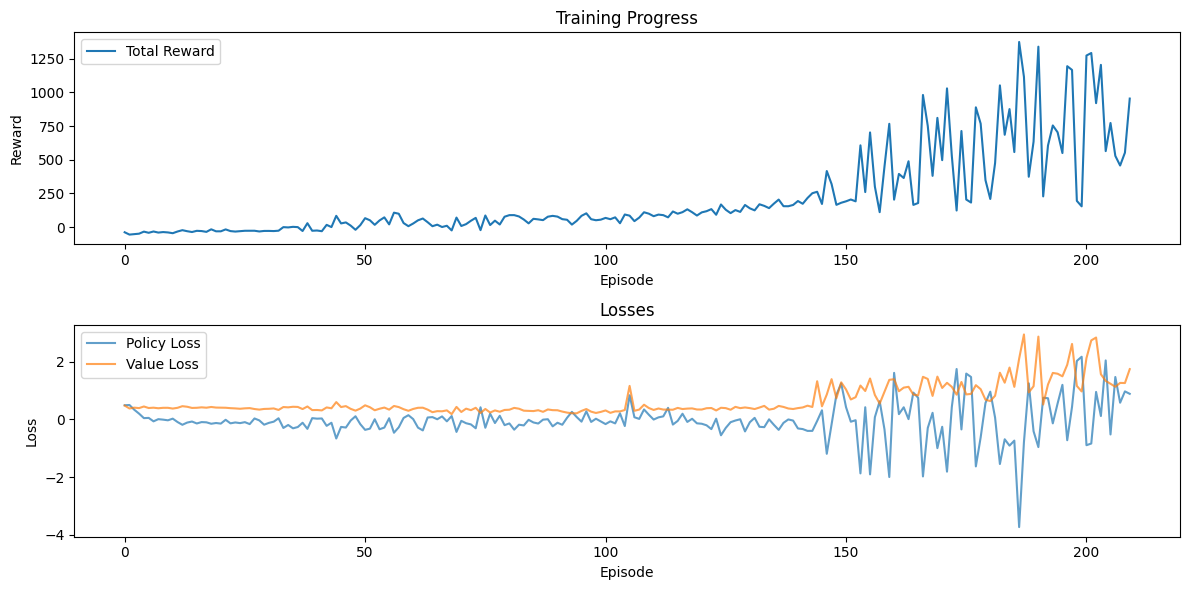

Test Episode: 210, Total Reward: 954.53
Episode: 211, Total Reward: 1227.36, Policy Loss: 0.3361, Value Loss: 2.4837
tensor([0.4844, 0.7389, 0.1397], device='cuda:0'), tensor([0.0725, 0.0546, 0.0393], device='cuda:0')
Episode: 212, Total Reward: 1296.50, Policy Loss: -0.0100, Value Loss: 1.6830
tensor([0.4847, 0.7398, 0.1391], device='cuda:0'), tensor([0.0741, 0.0551, 0.0407], device='cuda:0')
Episode: 213, Total Reward: 757.70, Policy Loss: 0.7863, Value Loss: 0.9616
tensor([0.4653, 0.7253, 0.1662], device='cuda:0'), tensor([0.0895, 0.0789, 0.0739], device='cuda:0')
Episode: 214, Total Reward: 1269.58, Policy Loss: -0.4170, Value Loss: 1.2954
tensor([0.4821, 0.7372, 0.1416], device='cuda:0'), tensor([0.0747, 0.0581, 0.0463], device='cuda:0')
Episode: 215, Total Reward: 1074.66, Policy Loss: 1.0828, Value Loss: 1.2943
tensor([0.4698, 0.7353, 0.1445], device='cuda:0'), tensor([0.0785, 0.0613, 0.0515], device='cuda:0')
Episode: 216, Total Reward: 1222.18, Policy Loss: 0.1623, Value Loss:

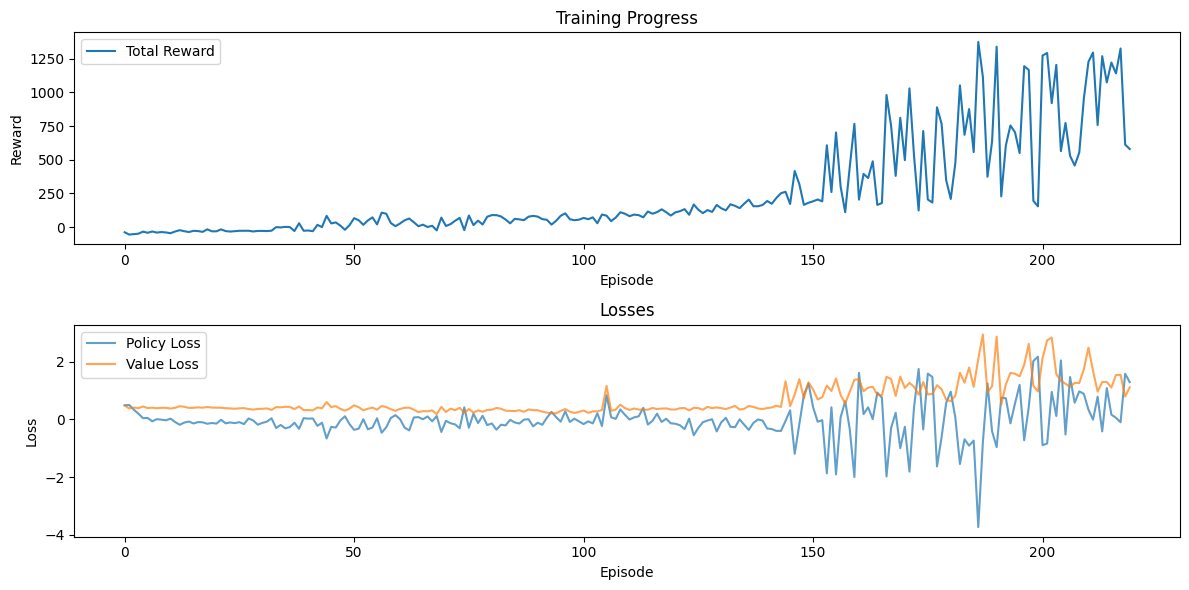

Test Episode: 220, Total Reward: 579.86
Episode: 221, Total Reward: 510.87, Policy Loss: 1.1343, Value Loss: 0.8575
tensor([0.4168, 0.6728, 0.2438], device='cuda:0'), tensor([0.1552, 0.1778, 0.2051], device='cuda:0')
Episode: 222, Total Reward: 782.78, Policy Loss: -0.3762, Value Loss: 0.8173
tensor([0.4207, 0.6955, 0.2185], device='cuda:0'), tensor([0.1456, 0.1530, 0.1934], device='cuda:0')
Episode: 223, Total Reward: 1403.41, Policy Loss: -0.6018, Value Loss: 2.1188
tensor([0.4759, 0.7380, 0.1441], device='cuda:0'), tensor([0.0809, 0.0618, 0.0549], device='cuda:0')
Episode: 224, Total Reward: 1432.11, Policy Loss: -0.0189, Value Loss: 1.7335
tensor([0.4812, 0.7451, 0.1398], device='cuda:0'), tensor([0.0768, 0.0528, 0.0396], device='cuda:0')
Episode: 225, Total Reward: 953.59, Policy Loss: 0.5054, Value Loss: 1.3244
tensor([0.4399, 0.7159, 0.1867], device='cuda:0'), tensor([0.1206, 0.1216, 0.1461], device='cuda:0')
Episode: 226, Total Reward: 1191.02, Policy Loss: 1.8438, Value Loss: 

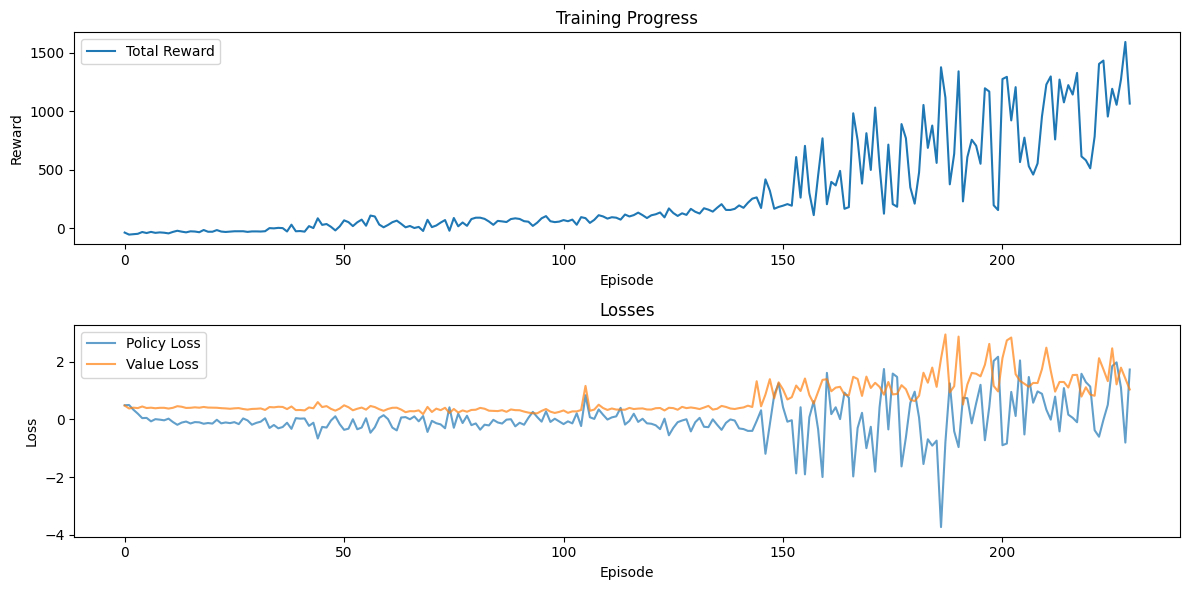

Test Episode: 230, Total Reward: 1064.37
Episode: 231, Total Reward: 996.03, Policy Loss: 1.8591, Value Loss: 2.7267
tensor([0.4680, 0.7420, 0.1470], device='cuda:0'), tensor([0.0916, 0.0650, 0.0539], device='cuda:0')
Episode: 232, Total Reward: 1110.18, Policy Loss: 1.1378, Value Loss: 1.3831
tensor([0.4718, 0.7418, 0.1503], device='cuda:0'), tensor([0.0853, 0.0643, 0.0590], device='cuda:0')
Episode: 233, Total Reward: 358.80, Policy Loss: 2.5949, Value Loss: 0.9780
tensor([0.3397, 0.5772, 0.3114], device='cuda:0'), tensor([0.1844, 0.2631, 0.2666], device='cuda:0')
Episode: 234, Total Reward: 1469.47, Policy Loss: 0.0297, Value Loss: 2.4529
tensor([0.4831, 0.7531, 0.1299], device='cuda:0'), tensor([0.0745, 0.0516, 0.0395], device='cuda:0')
Episode: 235, Total Reward: 641.79, Policy Loss: 1.1981, Value Loss: 1.2116
tensor([0.4041, 0.6571, 0.2164], device='cuda:0'), tensor([0.1480, 0.2066, 0.1916], device='cuda:0')
Episode: 236, Total Reward: 258.63, Policy Loss: 2.1296, Value Loss: 0.7

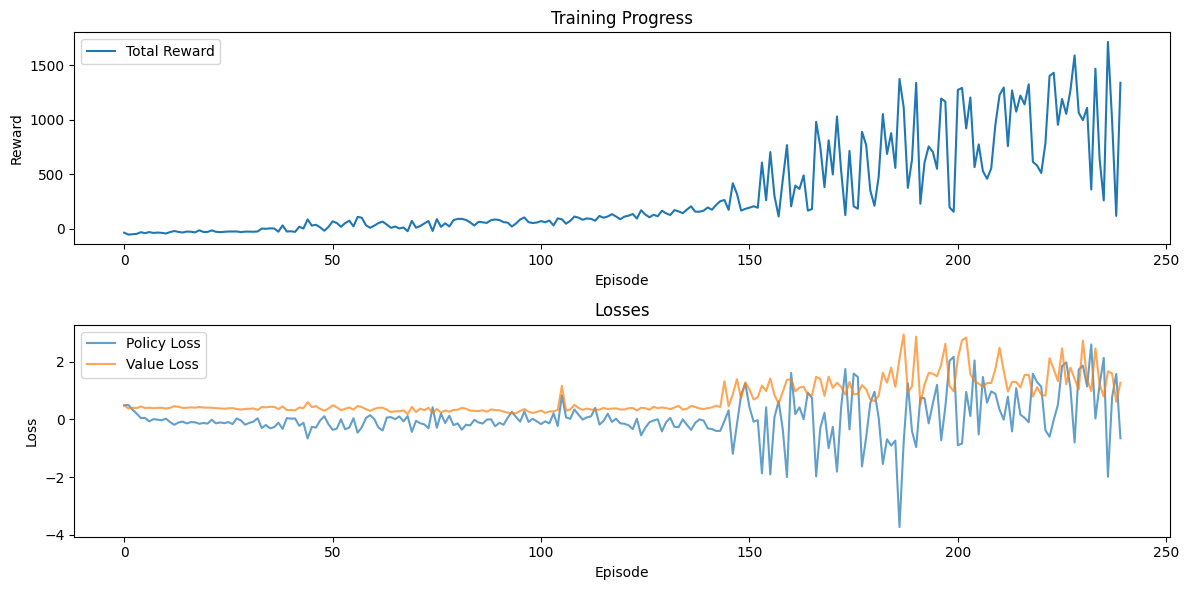

Test Episode: 240, Total Reward: 1340.25
Episode: 241, Total Reward: 1404.25, Policy Loss: -0.7904, Value Loss: 1.0199
tensor([0.4812, 0.7527, 0.1325], device='cuda:0'), tensor([0.0764, 0.0596, 0.0470], device='cuda:0')
Episode: 242, Total Reward: 679.71, Policy Loss: 0.0823, Value Loss: 0.8769
tensor([0.3654, 0.5810, 0.2783], device='cuda:0'), tensor([0.1825, 0.2760, 0.2605], device='cuda:0')
Episode: 243, Total Reward: 1377.71, Policy Loss: 0.1271, Value Loss: 2.5915
tensor([0.4770, 0.7493, 0.1351], device='cuda:0'), tensor([0.0853, 0.0585, 0.0507], device='cuda:0')
Episode: 244, Total Reward: 695.13, Policy Loss: 1.1121, Value Loss: 1.3462
tensor([0.3716, 0.6041, 0.2699], device='cuda:0'), tensor([0.1909, 0.2633, 0.2552], device='cuda:0')
Episode: 245, Total Reward: 1147.05, Policy Loss: 1.0915, Value Loss: 3.4234
tensor([0.4638, 0.7502, 0.1337], device='cuda:0'), tensor([0.0897, 0.0671, 0.0529], device='cuda:0')
Episode: 246, Total Reward: 937.81, Policy Loss: 0.4154, Value Loss: 1

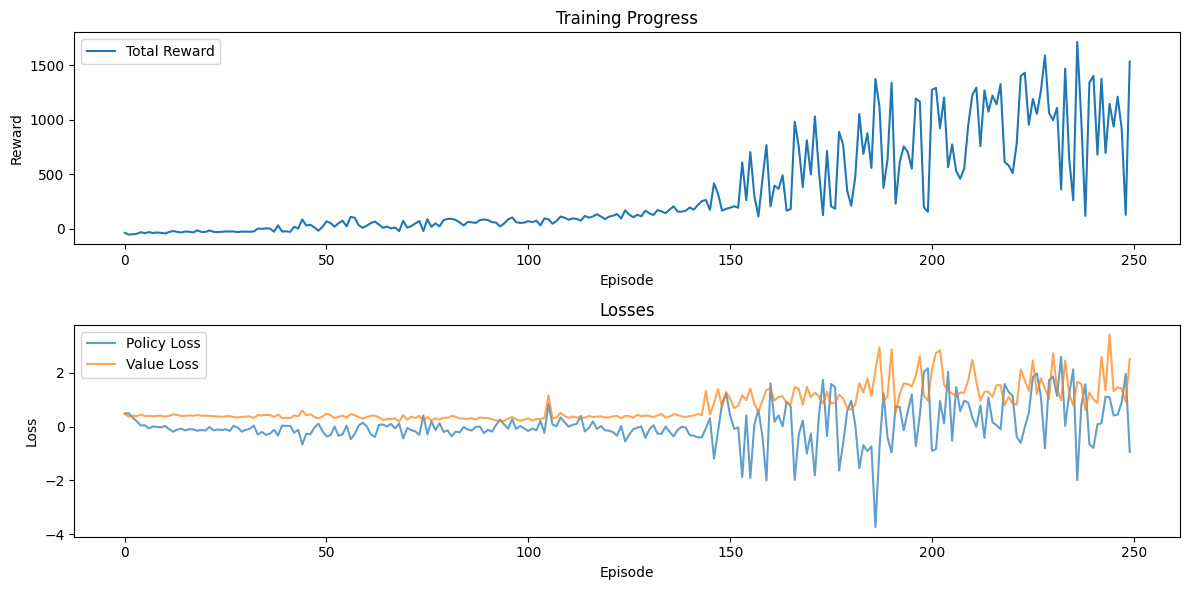

Test Episode: 250, Total Reward: 1535.43
Episode: 251, Total Reward: 1481.86, Policy Loss: -0.4702, Value Loss: 3.4442
tensor([0.4798, 0.7530, 0.1270], device='cuda:0'), tensor([0.0816, 0.0533, 0.0406], device='cuda:0')
Episode: 252, Total Reward: 1342.74, Policy Loss: -0.3817, Value Loss: 1.3074
tensor([0.4755, 0.7471, 0.1294], device='cuda:0'), tensor([0.0827, 0.0660, 0.0466], device='cuda:0')
Episode: 253, Total Reward: 1714.19, Policy Loss: -1.6252, Value Loss: 2.1904
tensor([0.4848, 0.7526, 0.1206], device='cuda:0'), tensor([0.0774, 0.0526, 0.0401], device='cuda:0')
Episode: 254, Total Reward: 1518.07, Policy Loss: -0.5764, Value Loss: 1.9393
tensor([0.4781, 0.7506, 0.1284], device='cuda:0'), tensor([0.0947, 0.0613, 0.0502], device='cuda:0')
Episode: 255, Total Reward: 1788.10, Policy Loss: -1.5907, Value Loss: 2.4466
tensor([0.4784, 0.7587, 0.1198], device='cuda:0'), tensor([0.0812, 0.0499, 0.0366], device='cuda:0')
Episode: 256, Total Reward: 793.30, Policy Loss: 0.5535, Value L

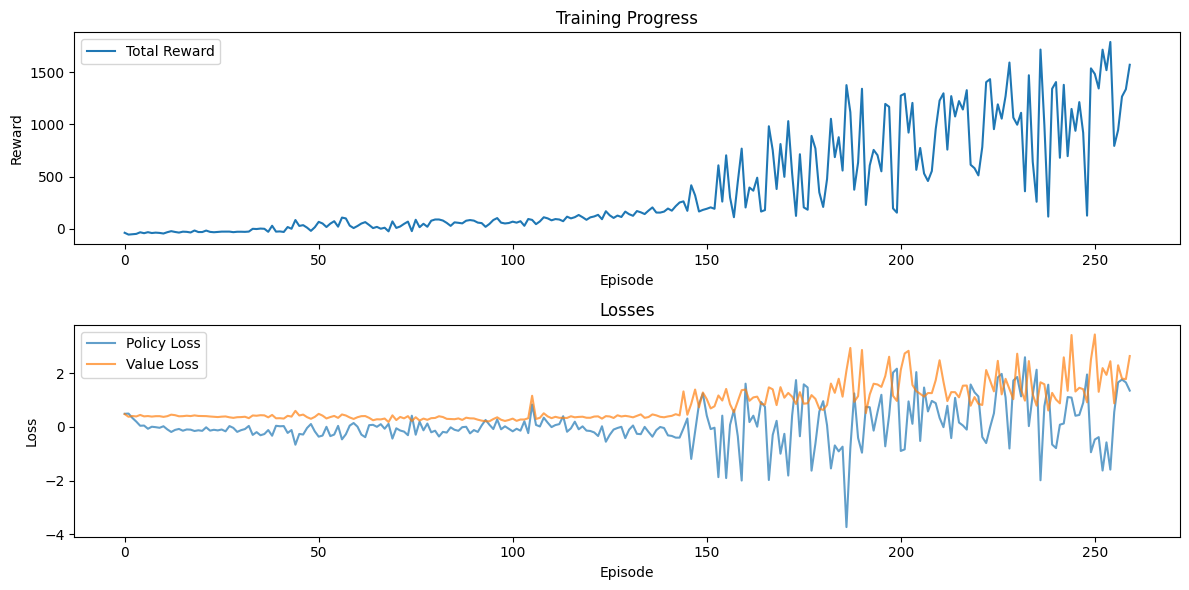

Test Episode: 260, Total Reward: 1569.81
Episode: 261, Total Reward: 1048.36, Policy Loss: 0.5875, Value Loss: 1.5646
tensor([0.4541, 0.7428, 0.1387], device='cuda:0'), tensor([0.1027, 0.0863, 0.0678], device='cuda:0')
Episode: 262, Total Reward: 1397.23, Policy Loss: 0.3047, Value Loss: 2.2468
tensor([0.4644, 0.7518, 0.1294], device='cuda:0'), tensor([0.0946, 0.0677, 0.0522], device='cuda:0')
Episode: 263, Total Reward: 787.32, Policy Loss: 1.4372, Value Loss: 1.1660
tensor([0.4038, 0.6533, 0.2097], device='cuda:0'), tensor([0.1605, 0.2295, 0.2063], device='cuda:0')
Episode: 264, Total Reward: 1464.86, Policy Loss: 1.3261, Value Loss: 2.7966
tensor([0.4782, 0.7583, 0.1237], device='cuda:0'), tensor([0.0828, 0.0590, 0.0497], device='cuda:0')
Episode: 265, Total Reward: 1640.28, Policy Loss: -0.4941, Value Loss: 2.4242
tensor([0.4683, 0.7580, 0.1262], device='cuda:0'), tensor([0.0946, 0.0582, 0.0441], device='cuda:0')
Episode: 266, Total Reward: 1308.64, Policy Loss: 1.5233, Value Loss:

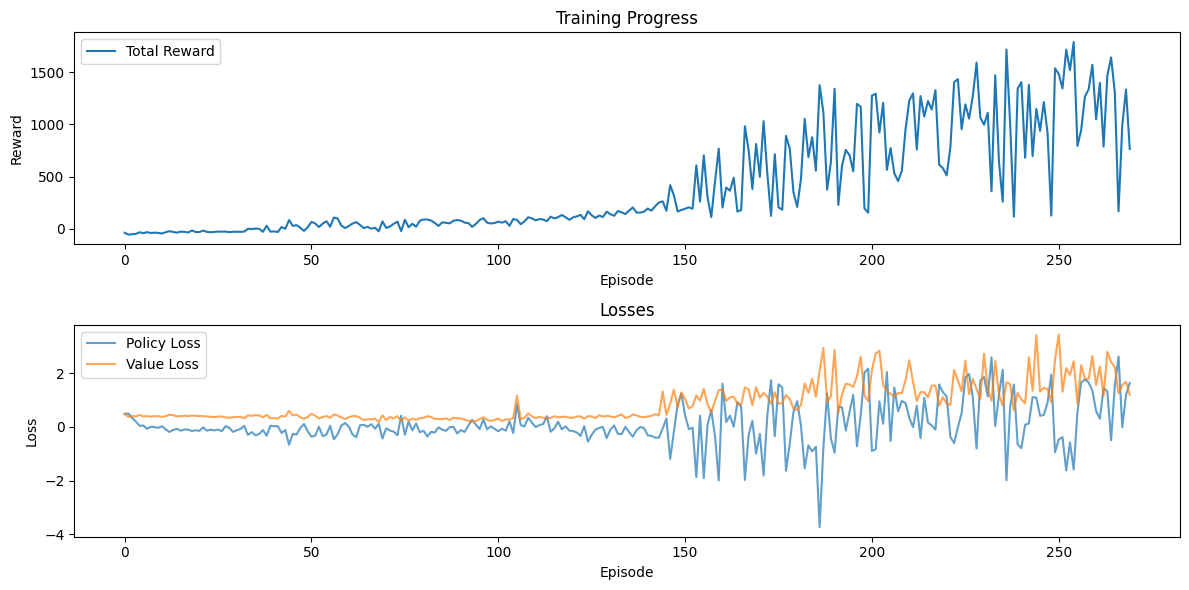

Test Episode: 270, Total Reward: 763.48
Episode: 271, Total Reward: 1510.07, Policy Loss: 0.6512, Value Loss: 2.8257
tensor([0.4744, 0.7555, 0.1190], device='cuda:0'), tensor([0.0867, 0.0595, 0.0409], device='cuda:0')
Episode: 272, Total Reward: 979.13, Policy Loss: 0.6775, Value Loss: 2.5815
tensor([0.4389, 0.7242, 0.1493], device='cuda:0'), tensor([0.1211, 0.1212, 0.1045], device='cuda:0')
Episode: 273, Total Reward: 1430.06, Policy Loss: 0.0880, Value Loss: 1.4120
tensor([0.4688, 0.7502, 0.1220], device='cuda:0'), tensor([0.0877, 0.0663, 0.0454], device='cuda:0')
Episode: 274, Total Reward: 1344.08, Policy Loss: 0.4358, Value Loss: 1.7616
tensor([0.4637, 0.7415, 0.1312], device='cuda:0'), tensor([0.0961, 0.0719, 0.0559], device='cuda:0')
Episode: 275, Total Reward: 1458.26, Policy Loss: 0.2489, Value Loss: 1.8605
tensor([0.4770, 0.7537, 0.1259], device='cuda:0'), tensor([0.0942, 0.0597, 0.0460], device='cuda:0')
Episode: 276, Total Reward: 1445.06, Policy Loss: 1.3831, Value Loss: 2

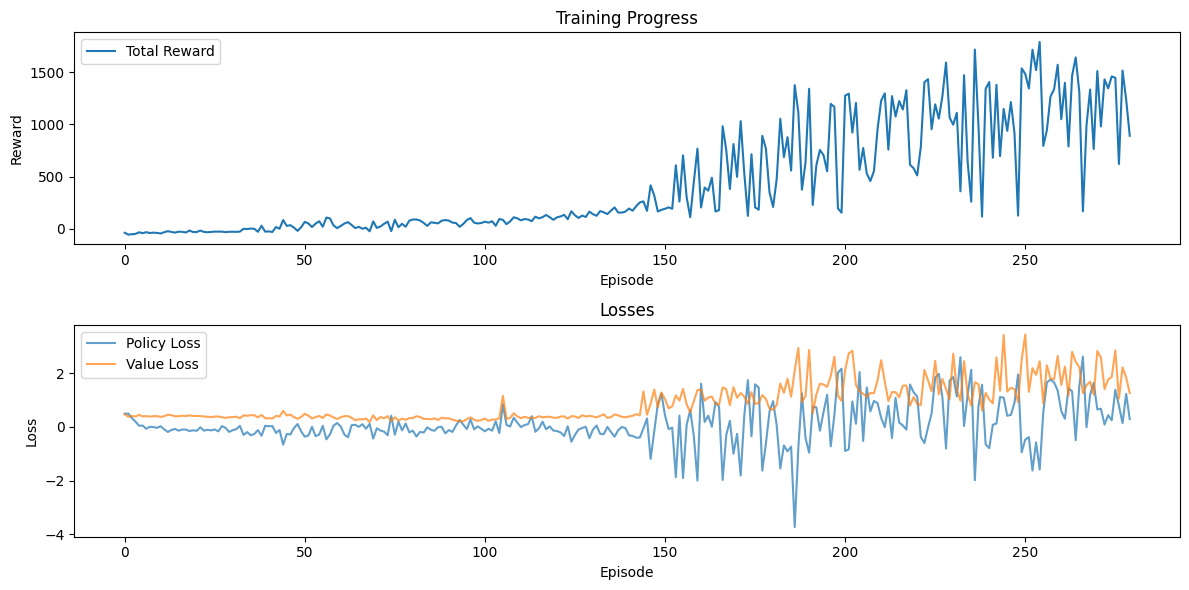

Test Episode: 280, Total Reward: 890.13
Episode: 281, Total Reward: 1572.18, Policy Loss: -0.2009, Value Loss: 2.1669
tensor([0.4649, 0.7558, 0.1208], device='cuda:0'), tensor([0.0990, 0.0639, 0.0458], device='cuda:0')
Episode: 282, Total Reward: 1374.43, Policy Loss: 0.5531, Value Loss: 2.2862
tensor([0.4588, 0.7507, 0.1257], device='cuda:0'), tensor([0.1038, 0.0635, 0.0480], device='cuda:0')
Episode: 283, Total Reward: 1327.44, Policy Loss: 1.4627, Value Loss: 2.4385
tensor([0.4690, 0.7514, 0.1234], device='cuda:0'), tensor([0.0942, 0.0662, 0.0474], device='cuda:0')
Episode: 284, Total Reward: 433.55, Policy Loss: 2.7411, Value Loss: 1.5266
tensor([0.3203, 0.5367, 0.2916], device='cuda:0'), tensor([0.1975, 0.2955, 0.2735], device='cuda:0')
Episode: 285, Total Reward: 755.21, Policy Loss: 1.9369, Value Loss: 1.1381
tensor([0.3948, 0.6460, 0.1992], device='cuda:0'), tensor([0.1665, 0.2328, 0.2086], device='cuda:0')
Episode: 286, Total Reward: 1554.28, Policy Loss: 0.1032, Value Loss: 1

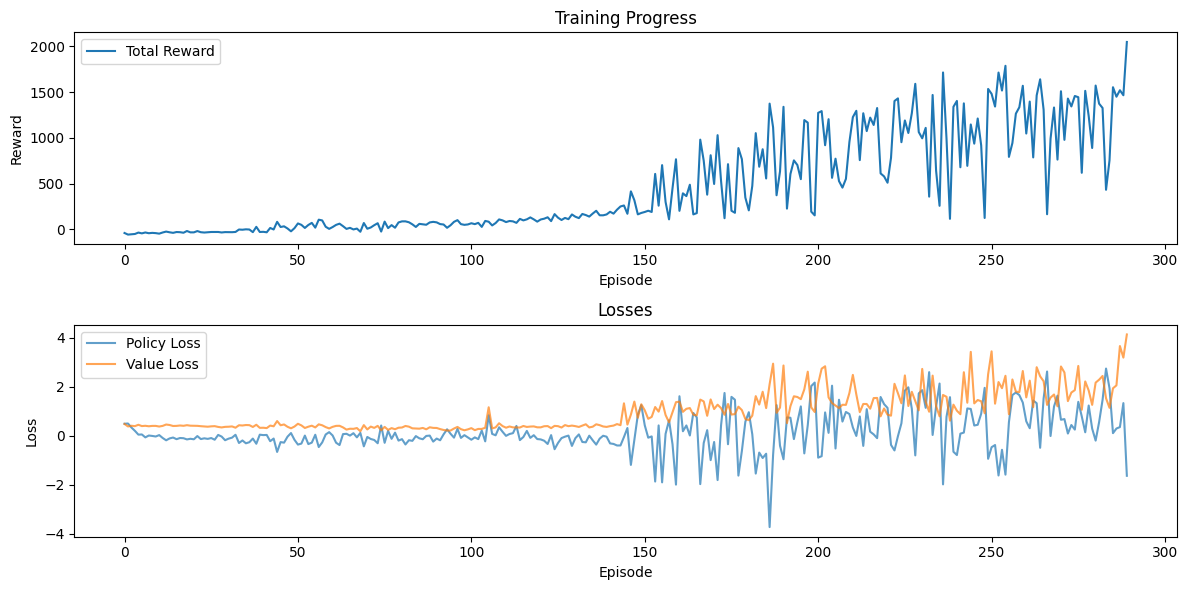

Test Episode: 290, Total Reward: 2048.48
Episode: 291, Total Reward: 853.15, Policy Loss: 0.3462, Value Loss: 1.0693
tensor([0.3713, 0.6056, 0.2248], device='cuda:0'), tensor([0.1825, 0.2703, 0.2357], device='cuda:0')
Episode: 292, Total Reward: 1581.45, Policy Loss: 0.3679, Value Loss: 2.4618
tensor([0.4706, 0.7496, 0.1082], device='cuda:0'), tensor([0.0996, 0.0675, 0.0481], device='cuda:0')
Episode: 293, Total Reward: 1478.09, Policy Loss: 1.0736, Value Loss: 3.2383
tensor([0.4521, 0.7435, 0.1158], device='cuda:0'), tensor([0.1049, 0.0715, 0.0551], device='cuda:0')
Episode: 294, Total Reward: 577.47, Policy Loss: 2.4349, Value Loss: 1.2991
tensor([0.3460, 0.5725, 0.2475], device='cuda:0'), tensor([0.1923, 0.2916, 0.2564], device='cuda:0')
Episode: 295, Total Reward: 1434.80, Policy Loss: 0.9561, Value Loss: 2.0672
tensor([0.4689, 0.7493, 0.1082], device='cuda:0'), tensor([0.0968, 0.0704, 0.0483], device='cuda:0')
Episode: 296, Total Reward: 1674.09, Policy Loss: 1.3316, Value Loss: 3

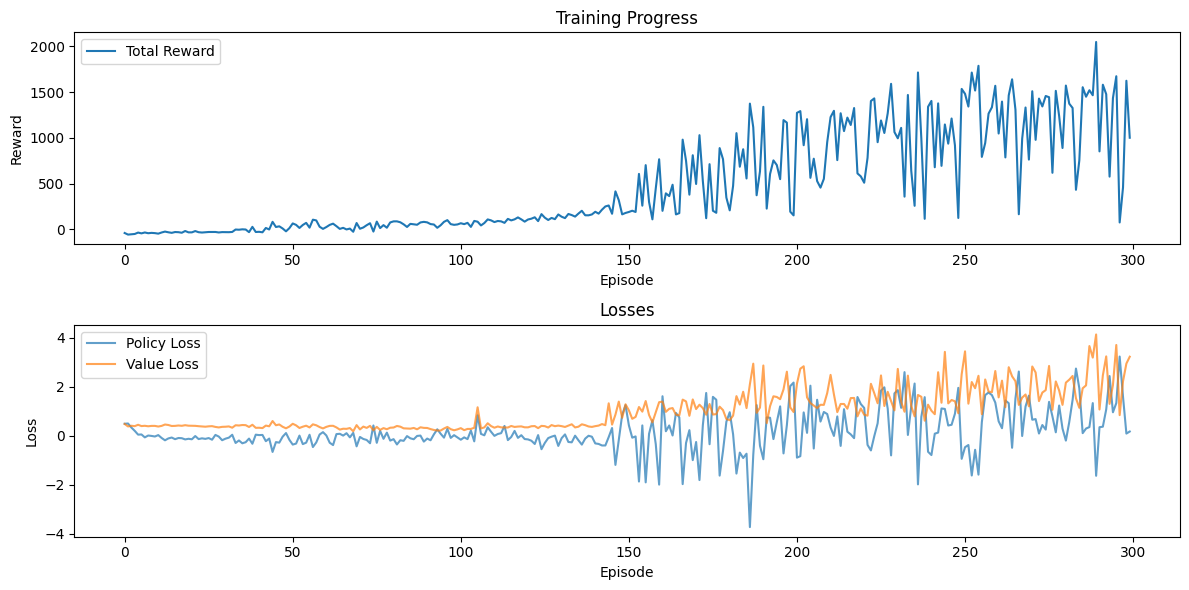

Test Episode: 300, Total Reward: 1002.14
Episode: 301, Total Reward: 1307.14, Policy Loss: 2.0653, Value Loss: 2.1285
tensor([0.4591, 0.7425, 0.1077], device='cuda:0'), tensor([0.1066, 0.0824, 0.0509], device='cuda:0')
Episode: 302, Total Reward: 1789.28, Policy Loss: 0.3316, Value Loss: 3.8321
tensor([0.4726, 0.7562, 0.1005], device='cuda:0'), tensor([0.0993, 0.0654, 0.0409], device='cuda:0')
Episode: 303, Total Reward: 1242.86, Policy Loss: 1.2271, Value Loss: 3.0461
tensor([0.4552, 0.7379, 0.1154], device='cuda:0'), tensor([0.1156, 0.0845, 0.0508], device='cuda:0')
Episode: 304, Total Reward: 1676.02, Policy Loss: 1.0540, Value Loss: 3.4778
tensor([0.4704, 0.7496, 0.1024], device='cuda:0'), tensor([0.0991, 0.0720, 0.0432], device='cuda:0')
Episode: 305, Total Reward: 1735.84, Policy Loss: 0.4935, Value Loss: 4.0743
tensor([0.4716, 0.7487, 0.1001], device='cuda:0'), tensor([0.0997, 0.0689, 0.0416], device='cuda:0')
Episode: 306, Total Reward: 1534.84, Policy Loss: 0.9732, Value Loss:

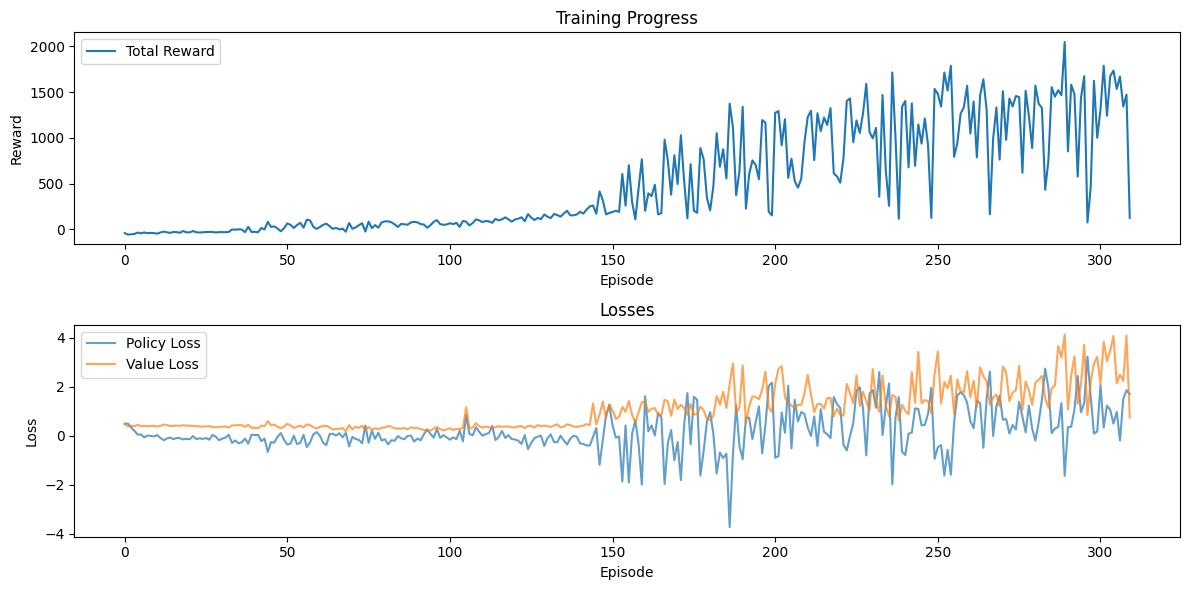

Test Episode: 310, Total Reward: 124.75
Episode: 311, Total Reward: 1402.12, Policy Loss: 0.2279, Value Loss: 4.4423
tensor([0.4377, 0.7411, 0.1146], device='cuda:0'), tensor([0.1216, 0.0737, 0.0552], device='cuda:0')
Episode: 312, Total Reward: 172.67, Policy Loss: 1.9406, Value Loss: 1.2716
tensor([0.3862, 0.6899, 0.1585], device='cuda:0'), tensor([0.1473, 0.1583, 0.1209], device='cuda:0')
Episode: 313, Total Reward: 586.96, Policy Loss: 0.2086, Value Loss: 1.6782
tensor([0.4017, 0.6952, 0.1524], device='cuda:0'), tensor([0.1493, 0.1676, 0.1306], device='cuda:0')
Episode: 314, Total Reward: 1505.77, Policy Loss: -0.4175, Value Loss: 4.2591
tensor([0.4711, 0.7475, 0.1053], device='cuda:0'), tensor([0.1103, 0.0727, 0.0484], device='cuda:0')
Episode: 315, Total Reward: 645.57, Policy Loss: 0.1538, Value Loss: 1.1707
tensor([0.4163, 0.7144, 0.1403], device='cuda:0'), tensor([0.1313, 0.1082, 0.0820], device='cuda:0')
Episode: 316, Total Reward: 1645.03, Policy Loss: -0.3873, Value Loss: 2

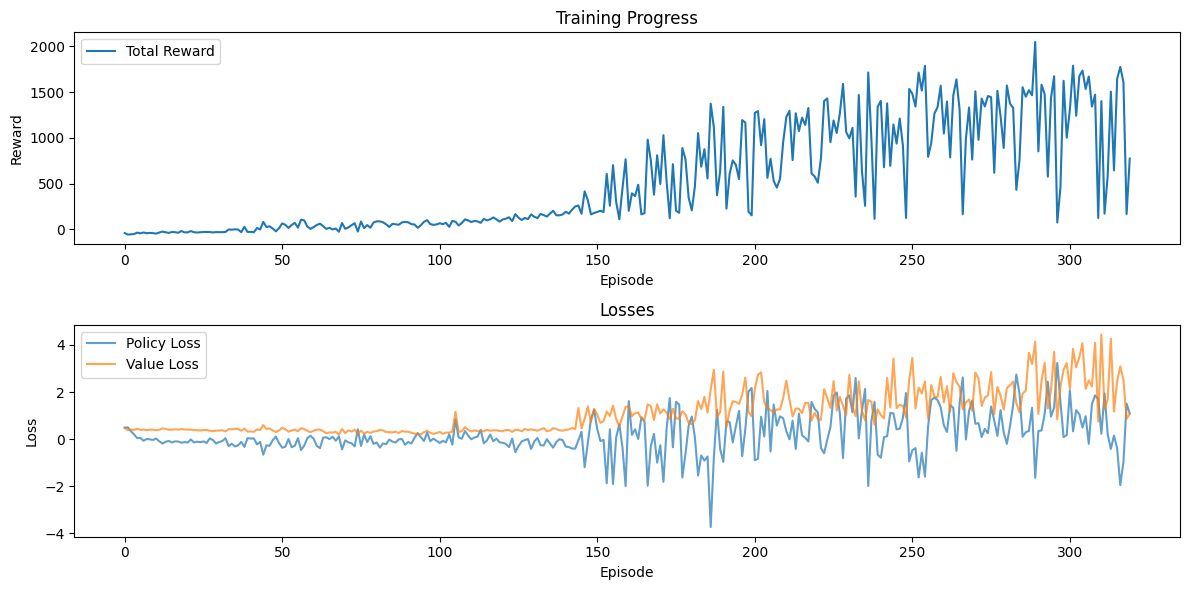

Test Episode: 320, Total Reward: 774.27
Episode: 321, Total Reward: 1434.65, Policy Loss: 0.4399, Value Loss: 3.5554
tensor([0.4623, 0.7387, 0.1077], device='cuda:0'), tensor([0.1181, 0.0811, 0.0513], device='cuda:0')
Episode: 322, Total Reward: 554.66, Policy Loss: 0.2500, Value Loss: 0.8911
tensor([0.4022, 0.6691, 0.1766], device='cuda:0'), tensor([0.1601, 0.2004, 0.1820], device='cuda:0')
Episode: 323, Total Reward: 1632.33, Policy Loss: 0.6724, Value Loss: 4.4607
tensor([0.4800, 0.7373, 0.0994], device='cuda:0'), tensor([0.1141, 0.0744, 0.0431], device='cuda:0')
Episode: 324, Total Reward: 1872.86, Policy Loss: -0.4563, Value Loss: 2.4640
tensor([0.4657, 0.7381, 0.1007], device='cuda:0'), tensor([0.1087, 0.0771, 0.0499], device='cuda:0')
Episode: 325, Total Reward: 1420.30, Policy Loss: 2.6067, Value Loss: 3.6781
tensor([0.4557, 0.7315, 0.1078], device='cuda:0'), tensor([0.1208, 0.0787, 0.0481], device='cuda:0')
Episode: 326, Total Reward: 1282.02, Policy Loss: 1.5441, Value Loss: 

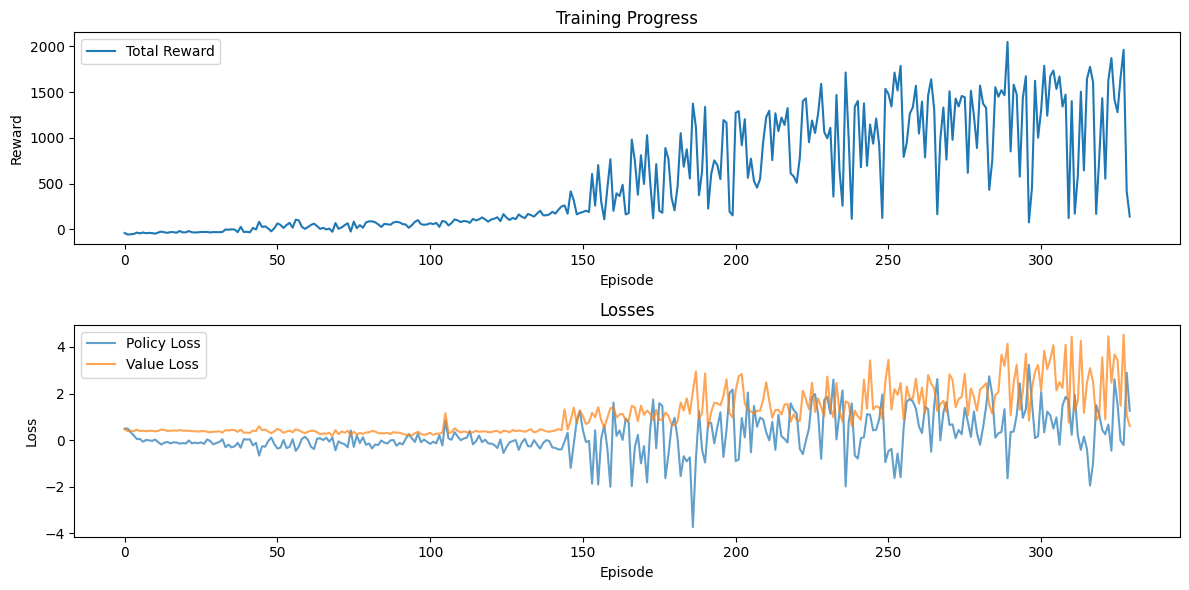

Test Episode: 330, Total Reward: 141.47
Episode: 331, Total Reward: 617.37, Policy Loss: 1.3227, Value Loss: 1.0546
tensor([0.3550, 0.5634, 0.2297], device='cuda:0'), tensor([0.1995, 0.2878, 0.2407], device='cuda:0')
Episode: 332, Total Reward: 1812.63, Policy Loss: -0.0503, Value Loss: 4.5875
tensor([0.4653, 0.7428, 0.0979], device='cuda:0'), tensor([0.1113, 0.0745, 0.0449], device='cuda:0')
Episode: 333, Total Reward: 1642.36, Policy Loss: 0.5426, Value Loss: 3.5468
tensor([0.4696, 0.7431, 0.1056], device='cuda:0'), tensor([0.1127, 0.0789, 0.0533], device='cuda:0')
Episode: 334, Total Reward: 721.03, Policy Loss: 4.2973, Value Loss: 1.6960
tensor([0.4692, 0.6778, 0.1259], device='cuda:0'), tensor([0.1233, 0.1953, 0.0725], device='cuda:0')
Episode: 335, Total Reward: 1870.08, Policy Loss: 0.2136, Value Loss: 4.6536
tensor([0.4680, 0.7467, 0.0970], device='cuda:0'), tensor([0.1070, 0.0727, 0.0418], device='cuda:0')
Episode: 336, Total Reward: 1772.37, Policy Loss: 0.5450, Value Loss: 2

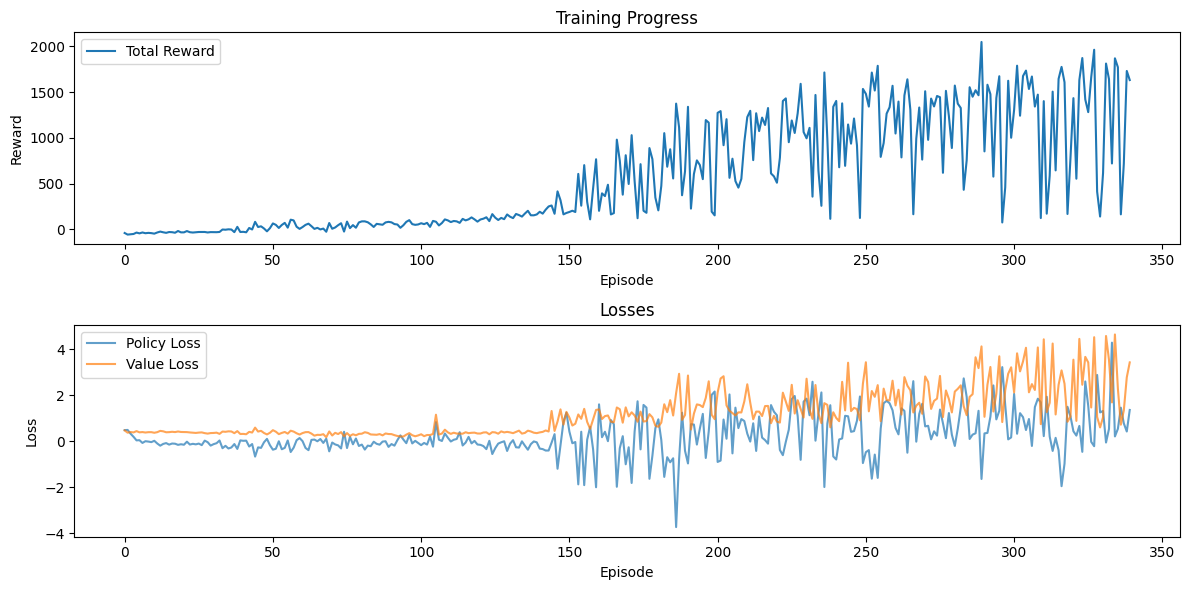

Test Episode: 340, Total Reward: 1632.46
Episode: 341, Total Reward: 1812.77, Policy Loss: 0.9250, Value Loss: 2.8046
tensor([0.4601, 0.7524, 0.1029], device='cuda:0'), tensor([0.1223, 0.0810, 0.0534], device='cuda:0')
Episode: 342, Total Reward: 1746.38, Policy Loss: 0.5095, Value Loss: 3.5673
tensor([0.4602, 0.7521, 0.1005], device='cuda:0'), tensor([0.1140, 0.0801, 0.0523], device='cuda:0')
Episode: 343, Total Reward: 1491.58, Policy Loss: 1.3875, Value Loss: 1.8986
tensor([0.4756, 0.7527, 0.1032], device='cuda:0'), tensor([0.1080, 0.0858, 0.0583], device='cuda:0')
Episode: 344, Total Reward: 1425.71, Policy Loss: 0.8640, Value Loss: 2.6034
tensor([0.4710, 0.7215, 0.1099], device='cuda:0'), tensor([0.1231, 0.1457, 0.0640], device='cuda:0')
Episode: 345, Total Reward: 724.07, Policy Loss: 0.3391, Value Loss: 1.3824
tensor([0.4513, 0.7344, 0.1317], device='cuda:0'), tensor([0.1215, 0.1134, 0.0823], device='cuda:0')
Episode: 346, Total Reward: 1578.19, Policy Loss: 1.1089, Value Loss: 

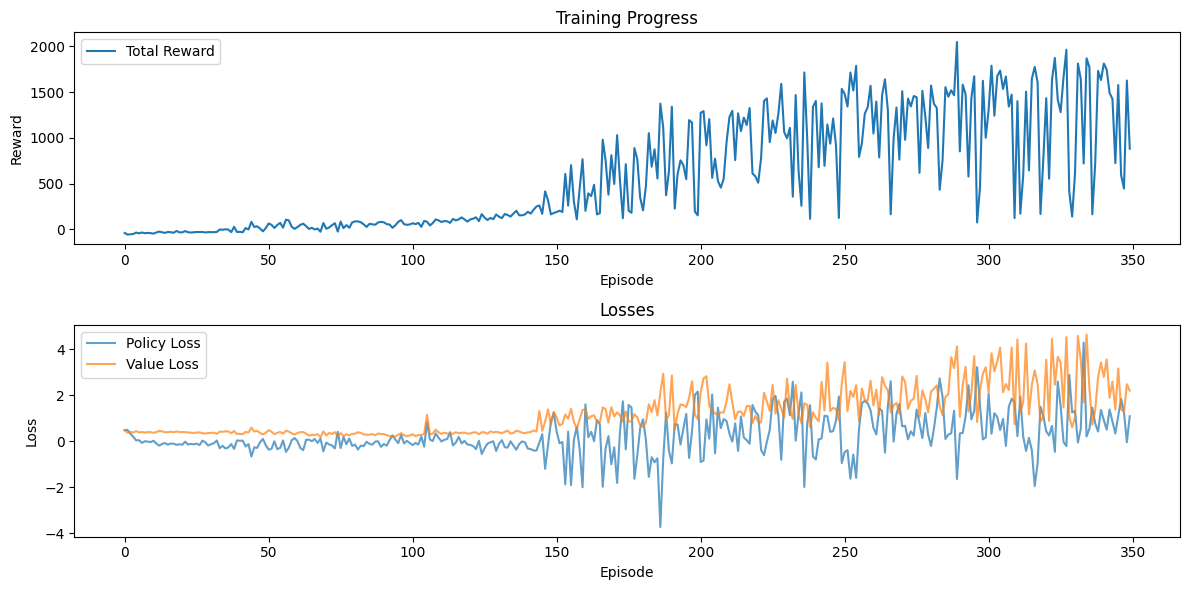

Test Episode: 350, Total Reward: 882.35
Episode: 351, Total Reward: 986.94, Policy Loss: 0.7146, Value Loss: 1.7339
tensor([0.4736, 0.7292, 0.1255], device='cuda:0'), tensor([0.1224, 0.1128, 0.0769], device='cuda:0')
Episode: 352, Total Reward: 962.47, Policy Loss: 0.7637, Value Loss: 1.6219
tensor([0.4162, 0.6493, 0.1795], device='cuda:0'), tensor([0.1699, 0.2432, 0.2007], device='cuda:0')
Episode: 353, Total Reward: 465.07, Policy Loss: 0.3191, Value Loss: 1.0516
tensor([0.4419, 0.7108, 0.1441], device='cuda:0'), tensor([0.1388, 0.1227, 0.0842], device='cuda:0')
Episode: 354, Total Reward: 1743.91, Policy Loss: -0.3065, Value Loss: 6.2841
tensor([0.4552, 0.7514, 0.0954], device='cuda:0'), tensor([0.1210, 0.0839, 0.0479], device='cuda:0')
Episode: 355, Total Reward: 2070.47, Policy Loss: -2.2825, Value Loss: 3.0902
tensor([0.4630, 0.7567, 0.0951], device='cuda:0'), tensor([0.1137, 0.0812, 0.0509], device='cuda:0')
Episode: 356, Total Reward: 1669.32, Policy Loss: 1.0673, Value Loss: 4

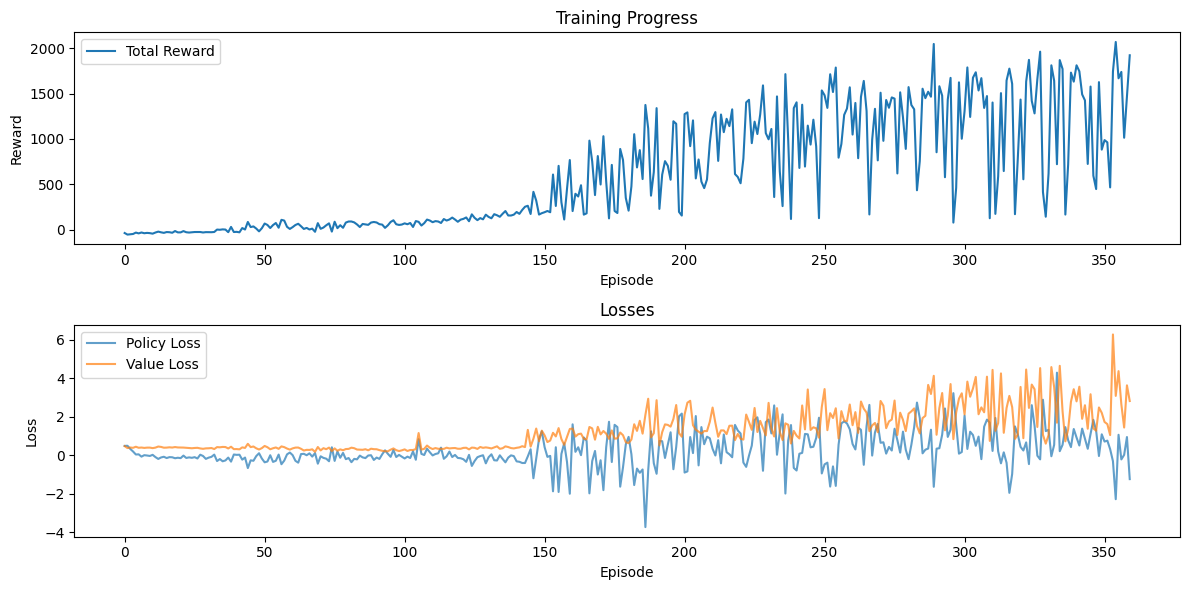

Test Episode: 360, Total Reward: 1923.54
Episode: 361, Total Reward: 2151.83, Policy Loss: -2.0629, Value Loss: 3.7560
tensor([0.4684, 0.7539, 0.0937], device='cuda:0'), tensor([0.1114, 0.0829, 0.0486], device='cuda:0')
Episode: 362, Total Reward: 1634.68, Policy Loss: -0.4503, Value Loss: 3.0328
tensor([0.4482, 0.7502, 0.1020], device='cuda:0'), tensor([0.1172, 0.0875, 0.0538], device='cuda:0')
Episode: 363, Total Reward: 421.39, Policy Loss: 2.2179, Value Loss: 1.0141
tensor([0.3307, 0.5551, 0.2641], device='cuda:0'), tensor([0.1935, 0.2935, 0.2706], device='cuda:0')
Episode: 364, Total Reward: 2016.59, Policy Loss: -0.6822, Value Loss: 2.4929
tensor([0.4759, 0.7326, 0.0947], device='cuda:0'), tensor([0.1226, 0.1330, 0.0481], device='cuda:0')
Episode: 365, Total Reward: 1097.56, Policy Loss: 0.8109, Value Loss: 2.4342
tensor([0.4270, 0.7286, 0.1217], device='cuda:0'), tensor([0.1320, 0.1104, 0.0706], device='cuda:0')
Episode: 366, Total Reward: 1491.62, Policy Loss: 2.5309, Value Los

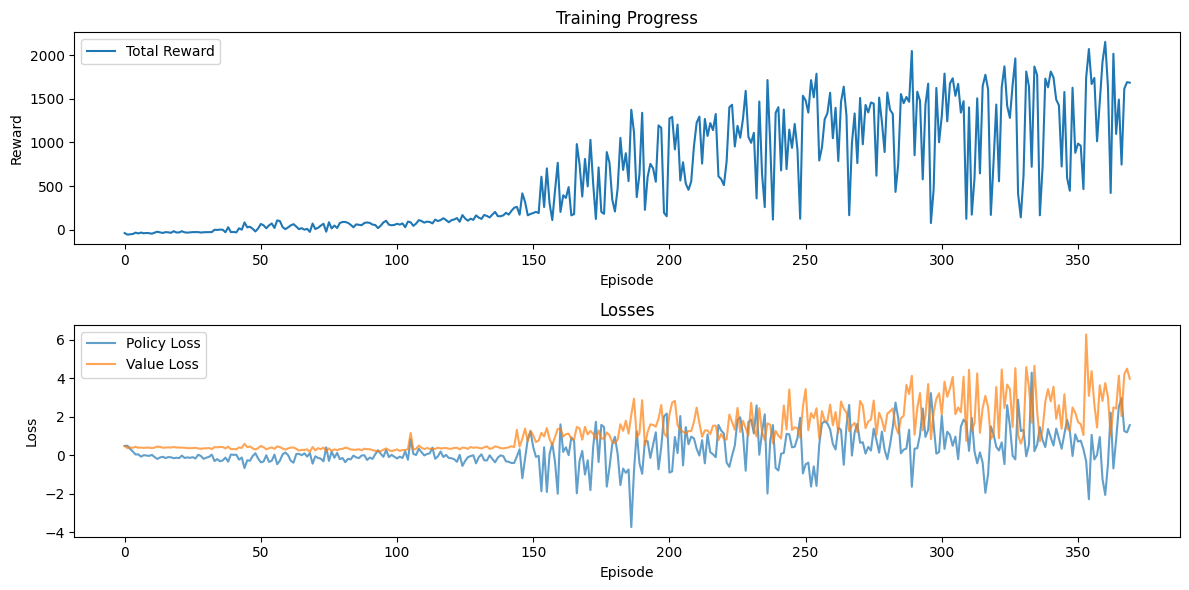

Test Episode: 370, Total Reward: 1685.47
Episode: 371, Total Reward: 1122.92, Policy Loss: 2.4726, Value Loss: 2.6257
tensor([0.4365, 0.7373, 0.1130], device='cuda:0'), tensor([0.1218, 0.1160, 0.0712], device='cuda:0')
Episode: 372, Total Reward: 938.92, Policy Loss: 0.4737, Value Loss: 2.4350
tensor([0.4320, 0.7141, 0.1196], device='cuda:0'), tensor([0.1328, 0.1484, 0.0813], device='cuda:0')
Episode: 373, Total Reward: 1441.72, Policy Loss: 1.3999, Value Loss: 2.8716
tensor([0.4548, 0.7432, 0.1030], device='cuda:0'), tensor([0.1344, 0.1165, 0.0615], device='cuda:0')
Episode: 374, Total Reward: 902.47, Policy Loss: 1.7161, Value Loss: 1.4005
tensor([0.4359, 0.7216, 0.1190], device='cuda:0'), tensor([0.1270, 0.1358, 0.0817], device='cuda:0')
Episode: 375, Total Reward: 1412.03, Policy Loss: 0.2596, Value Loss: 2.9790
tensor([0.4442, 0.7443, 0.1077], device='cuda:0'), tensor([0.1255, 0.1161, 0.0689], device='cuda:0')
Episode: 376, Total Reward: 1774.43, Policy Loss: -0.3975, Value Loss: 

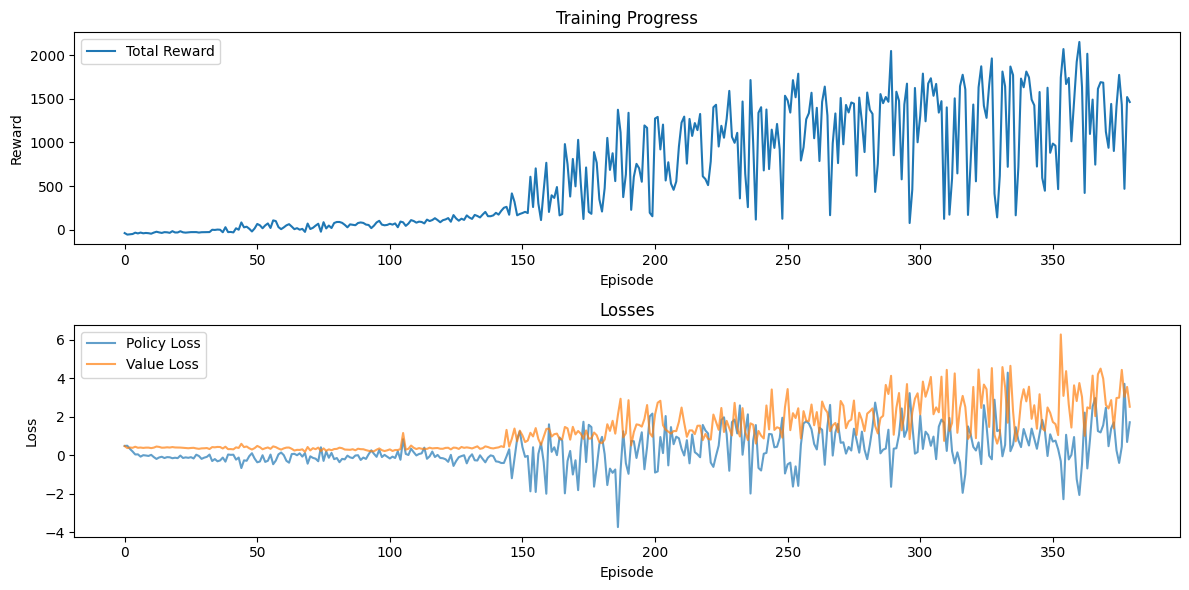

Test Episode: 380, Total Reward: 1463.73
Episode: 381, Total Reward: 97.38, Policy Loss: 5.0800, Value Loss: 3.3338
tensor([0.4580, 0.7175, 0.1186], device='cuda:0'), tensor([0.1514, 0.1489, 0.0782], device='cuda:0')
Episode: 382, Total Reward: 1841.88, Policy Loss: -1.8818, Value Loss: 4.3594
tensor([0.4632, 0.7610, 0.0901], device='cuda:0'), tensor([0.1256, 0.0973, 0.0530], device='cuda:0')
Episode: 383, Total Reward: 862.29, Policy Loss: 0.2697, Value Loss: 1.8317
tensor([0.3966, 0.6791, 0.1655], device='cuda:0'), tensor([0.1727, 0.2235, 0.1977], device='cuda:0')
Episode: 384, Total Reward: 759.02, Policy Loss: 1.3414, Value Loss: 2.0869
tensor([0.4061, 0.6896, 0.1384], device='cuda:0'), tensor([0.1545, 0.2019, 0.1557], device='cuda:0')
Episode: 385, Total Reward: 809.81, Policy Loss: 4.0878, Value Loss: 4.9378
tensor([0.5050, 0.6686, 0.1286], device='cuda:0'), tensor([0.1535, 0.2457, 0.1264], device='cuda:0')
Episode: 386, Total Reward: 1472.43, Policy Loss: 0.4452, Value Loss: 4.6

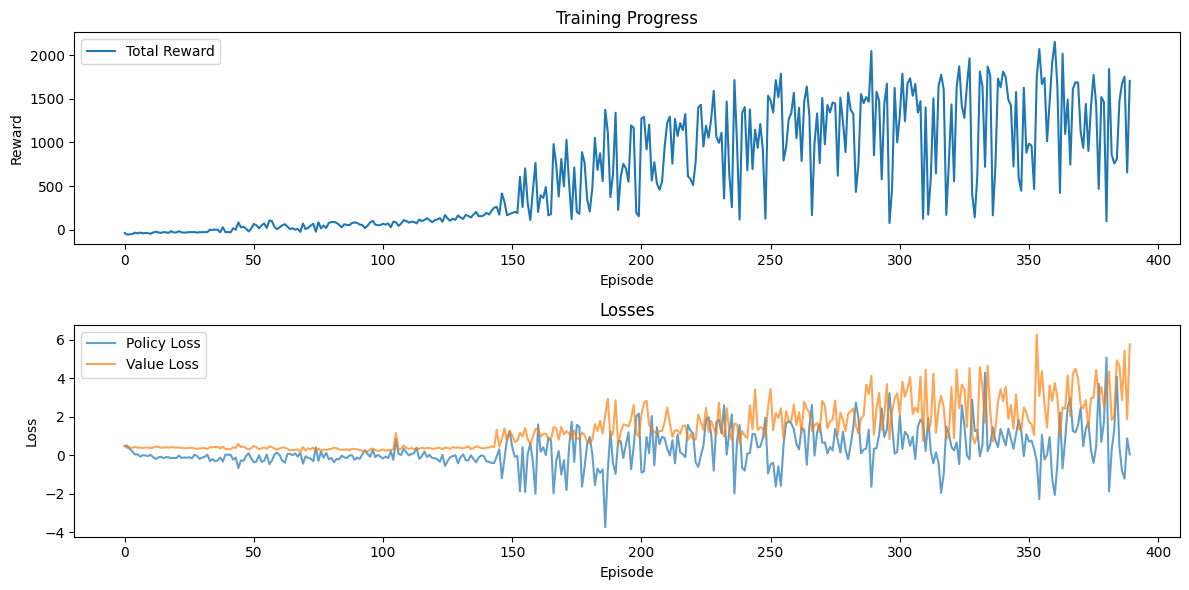

Test Episode: 390, Total Reward: 1705.67
Episode: 391, Total Reward: 772.44, Policy Loss: 1.3308, Value Loss: 3.6578
tensor([0.4566, 0.7413, 0.0998], device='cuda:0'), tensor([0.1393, 0.1167, 0.0659], device='cuda:0')
Episode: 392, Total Reward: 1093.18, Policy Loss: 0.2830, Value Loss: 3.8341
tensor([0.4556, 0.7477, 0.0968], device='cuda:0'), tensor([0.1415, 0.1052, 0.0606], device='cuda:0')
Episode: 393, Total Reward: 1407.21, Policy Loss: 1.2150, Value Loss: 4.0175
tensor([0.4723, 0.7514, 0.0850], device='cuda:0'), tensor([0.1418, 0.1132, 0.0552], device='cuda:0')
Episode: 394, Total Reward: 1622.03, Policy Loss: 1.0868, Value Loss: 4.7020
tensor([0.4702, 0.7495, 0.0791], device='cuda:0'), tensor([0.1352, 0.1157, 0.0532], device='cuda:0')
Episode: 395, Total Reward: 1185.95, Policy Loss: 3.3697, Value Loss: 6.4275
tensor([0.4745, 0.7641, 0.0851], device='cuda:0'), tensor([0.1462, 0.1066, 0.0553], device='cuda:0')
Episode: 396, Total Reward: 1338.42, Policy Loss: 1.5737, Value Loss: 

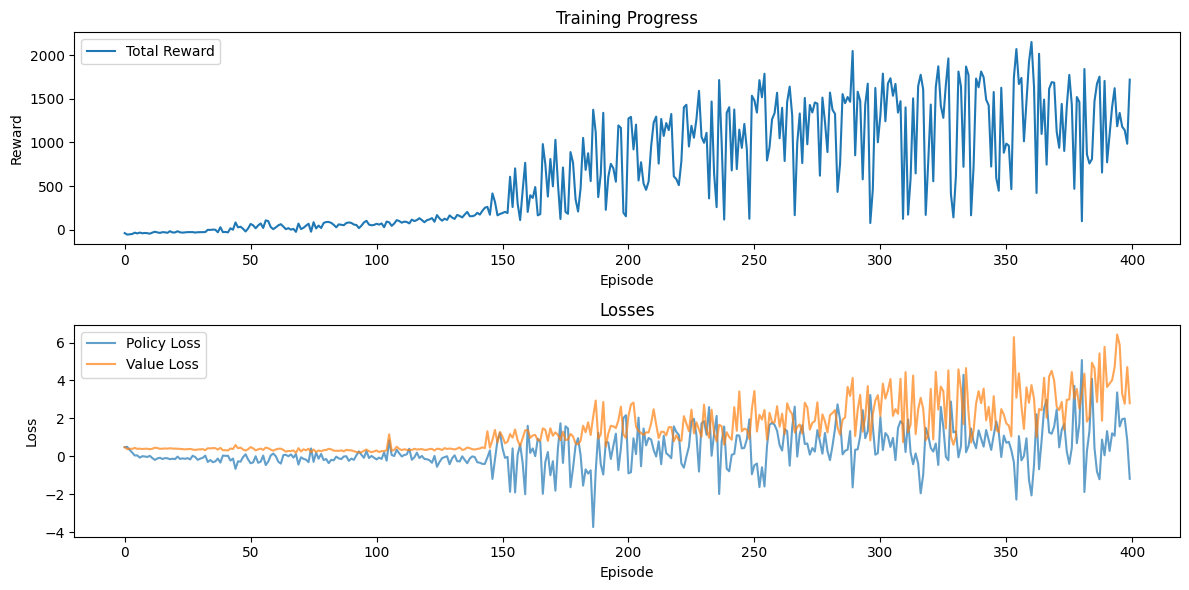

Test Episode: 400, Total Reward: 1720.44
Episode: 401, Total Reward: 1634.91, Policy Loss: -0.5533, Value Loss: 2.4024
tensor([0.4655, 0.7553, 0.0854], device='cuda:0'), tensor([0.1337, 0.1048, 0.0582], device='cuda:0')
Episode: 402, Total Reward: 1905.87, Policy Loss: -3.2776, Value Loss: 5.0399
tensor([0.4526, 0.7540, 0.0899], device='cuda:0'), tensor([0.1369, 0.0900, 0.0530], device='cuda:0')
Episode: 403, Total Reward: 1894.44, Policy Loss: -0.2528, Value Loss: 4.1927
tensor([0.4666, 0.7633, 0.0835], device='cuda:0'), tensor([0.1368, 0.0868, 0.0506], device='cuda:0')
Episode: 404, Total Reward: 1866.49, Policy Loss: -1.5362, Value Loss: 3.7066
tensor([0.4663, 0.7608, 0.0825], device='cuda:0'), tensor([0.1253, 0.0927, 0.0507], device='cuda:0')
Episode: 405, Total Reward: 1314.28, Policy Loss: 2.0131, Value Loss: 4.0860
tensor([0.4680, 0.7484, 0.0880], device='cuda:0'), tensor([0.1296, 0.1215, 0.0606], device='cuda:0')
Episode: 406, Total Reward: 1465.42, Policy Loss: 1.1163, Value L

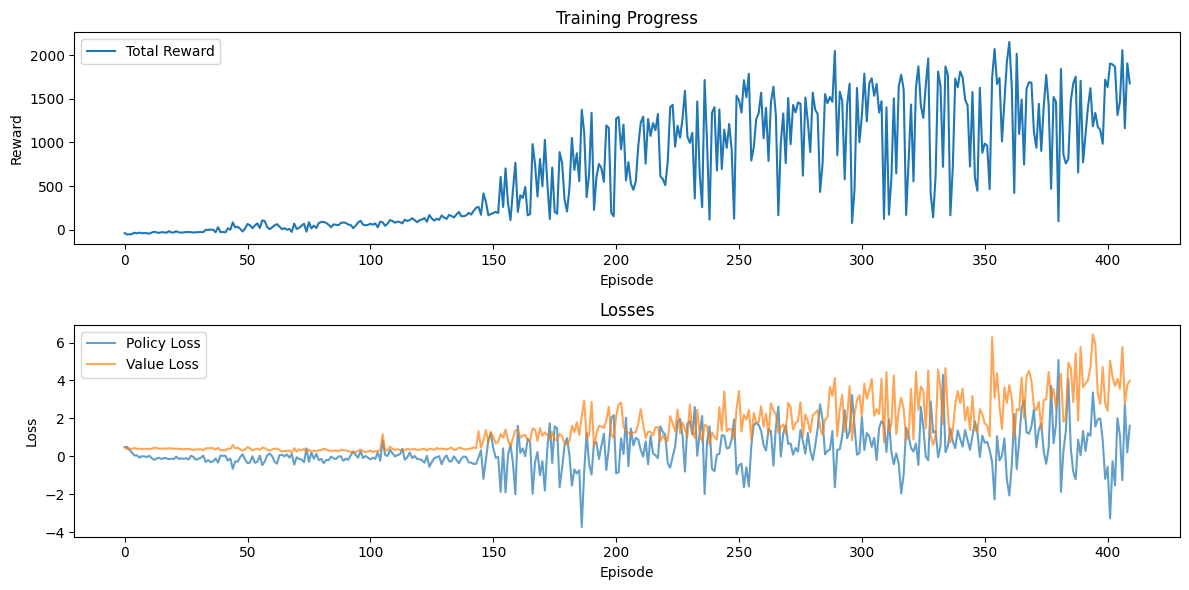

Test Episode: 410, Total Reward: 1677.00
Episode: 411, Total Reward: 1347.46, Policy Loss: 3.4325, Value Loss: 3.3099
tensor([0.4486, 0.7474, 0.0905], device='cuda:0'), tensor([0.1402, 0.1248, 0.0638], device='cuda:0')
Episode: 412, Total Reward: 105.66, Policy Loss: 2.1755, Value Loss: 2.1680
tensor([0.4270, 0.7551, 0.0869], device='cuda:0'), tensor([0.1208, 0.1111, 0.0618], device='cuda:0')
Episode: 413, Total Reward: 1613.08, Policy Loss: -0.8412, Value Loss: 2.8412
tensor([0.4710, 0.7633, 0.0855], device='cuda:0'), tensor([0.1458, 0.1032, 0.0537], device='cuda:0')
Episode: 414, Total Reward: 1797.52, Policy Loss: -1.4708, Value Loss: 3.7194
tensor([0.4607, 0.7649, 0.0797], device='cuda:0'), tensor([0.1245, 0.0972, 0.0515], device='cuda:0')
Episode: 415, Total Reward: 1885.58, Policy Loss: -1.3878, Value Loss: 5.7855
tensor([0.4631, 0.7736, 0.0807], device='cuda:0'), tensor([0.1362, 0.0874, 0.0488], device='cuda:0')
Episode: 416, Total Reward: 1795.08, Policy Loss: -1.1047, Value Lo

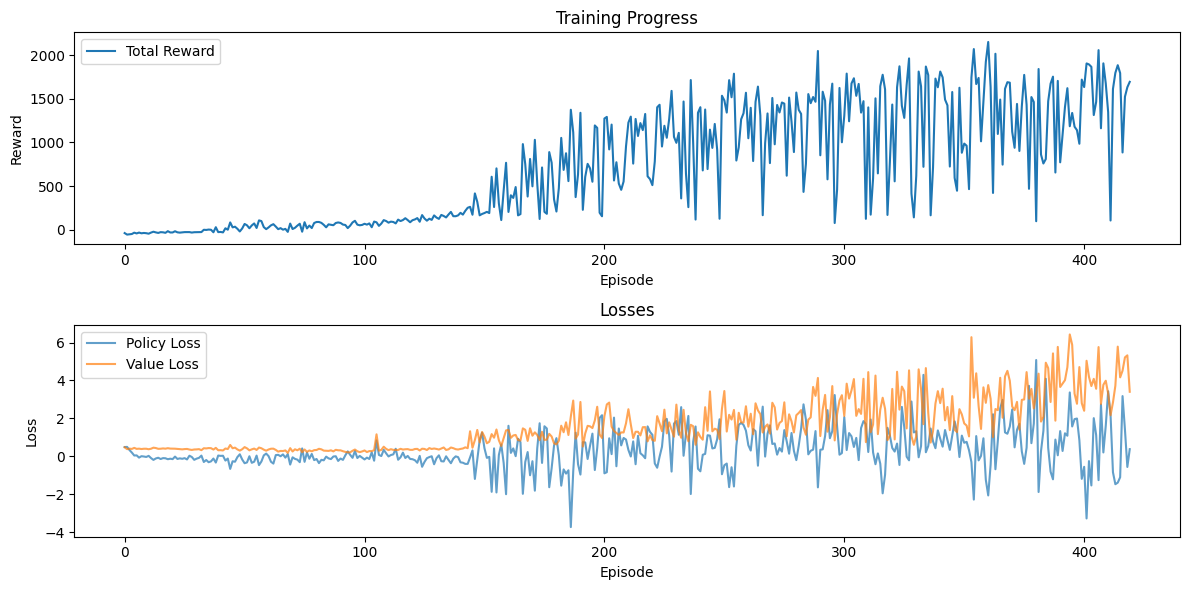

Test Episode: 420, Total Reward: 1694.79
Episode: 421, Total Reward: 830.78, Policy Loss: 1.7695, Value Loss: 3.0122
tensor([0.4447, 0.7606, 0.1068], device='cuda:0'), tensor([0.1299, 0.0946, 0.0652], device='cuda:0')
Episode: 422, Total Reward: 1676.66, Policy Loss: 0.3489, Value Loss: 4.2488
tensor([0.4706, 0.7713, 0.0792], device='cuda:0'), tensor([0.1384, 0.0865, 0.0522], device='cuda:0')
Episode: 423, Total Reward: 1802.36, Policy Loss: -0.3545, Value Loss: 2.7372
tensor([0.4669, 0.7651, 0.0785], device='cuda:0'), tensor([0.1387, 0.0888, 0.0518], device='cuda:0')
Episode: 424, Total Reward: 1564.53, Policy Loss: 0.0484, Value Loss: 3.8898
tensor([0.4717, 0.7594, 0.0837], device='cuda:0'), tensor([0.1384, 0.0910, 0.0563], device='cuda:0')
Episode: 425, Total Reward: 850.40, Policy Loss: 1.4935, Value Loss: 3.2595
tensor([0.4756, 0.7533, 0.0890], device='cuda:0'), tensor([0.1320, 0.0995, 0.0621], device='cuda:0')
Episode: 426, Total Reward: 1850.79, Policy Loss: -1.8929, Value Loss:

In [ ]:
for episode in range(10000):
    # 收集数据
    states, actions, log_probs_old, rewards, dones, values, last_next_state = collect_rollout(env, policy, num_steps)

    next_state = torch.FloatTensor(last_next_state).unsqueeze(0).to(device)
    # 计算GAE和returns
    with torch.no_grad():
        _, _, next_value = policy(next_state)
        returns, advantages = compute_gae(next_value, rewards, dones, values, gamma, lambda_gae)

    # 更新策略
    policy_loss, value_loss = ppo_update(policy, optimizer, states, actions, log_probs_old, returns, advantages)

    # 计算总奖励
    total_reward = rewards.sum().item()
    total_rewards.append(total_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward:.2f}, Policy Loss: {policy_loss:.4f}, Value Loss: {value_loss:.4f}")
    print(f"{actions.mean(axis=0)}, {actions.std(axis=0)}")

    # 可视化训练过程
    if (episode + 1) % 10 == 0:
        plt.figure(figsize=(12, 6))

        # 绘制奖励曲线
        plt.subplot(2, 1, 1)
        plt.plot(total_rewards, label='Total Reward')
        plt.title('Training Progress')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()

        # 绘制损失曲线
        plt.subplot(2, 1, 2)
        plt.plot(policy_losses, label='Policy Loss', alpha=0.7)
        plt.plot(value_losses, label='Value Loss', alpha=0.7)
        plt.title('Losses')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        # state = video_wrapper.reset()[0]
        # total_reward = 0
        # done = False
        # while not done:
        #     state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        #     with torch.no_grad():
        #         alpha, beta, _ = policy(state_tensor)
        #     dist = Beta(alpha, beta)
        #     action = dist.sample()
        #     action = action.squeeze().cpu().numpy()
        #     action = action * (env.action_space.high - env.action_space.low) + env.action_space.low
        #     next_state, reward, terminated, truncated, _ = video_wrapper.step(action)
        #     done = terminated or truncated
        #     total_reward += reward
        #     state = next_state
        # print(f"Test Episode: {episode + 1}, Total Reward: {total_reward:.2f}")
        # video_wrapper.close()

In [ ]:
# env.close()